In [1]:
import sympy as sp
from sympy import abc

In [2]:
from scipy.integrate import quad
from scipy.special import dawsn
import numpy as np
import scipy.optimize as opt
import numdifftools as nd

# Ферромагнетик

## Выражение для $Z^{(3)}$

### Определения

In [3]:
class SigmaSymbol(sp.Symbol):
    def _latex(self, printer, exp=None):
        if exp is None:
            return self.name
        else:
            exp = printer.doprint(exp)
            return f"{self.name}^{exp}"

    def _eval_power(self, expt):
        if expt.is_integer:
            d, m = divmod(expt, 2)
            return self**m


SIGMAS = [-1, 1]

### Аргументы

In [4]:
h_i, h_j = sp.symbols("h_i h_j", positive=True)
p = sp.Symbol("p", positive=True)
l_ij = sp.Symbol("\\lambda_{ij}", positive=True)
l_ik = sp.Symbol("\\lambda_{ik}", positive=True) 
s1, s2, s3 = SigmaSymbol("\\sigma_1"), SigmaSymbol("\\sigma_2"),  SigmaSymbol("\\sigma_3")

In [5]:
x, t = abc.x, abc.t
arg_exp = h_j*x
arg_exp = arg_exp.replace(
    x, sp.solve(sp.sqrt(h_i**2+l_ij**2+2*h_i*l_ij*x)-t, x)[0]
).expand()
arg_exp += (s1+s2)*t + s1*s2*l_ik
expr_limit = h_i+s3*l_ij
arg_F2 = (t+(s1+s2)*l_ik)/sp.sqrt(2*l_ik)

arg_exp = arg_exp.replace(t, t-(s1+s2)*l_ij*h_i/h_j).expand()
arg_F2 = arg_F2.replace(t, t-(s1+s2)*l_ij*h_i/h_j).expand()
expr_limit += (s1+s2)*l_ij*h_i/h_j

arg_exp = arg_exp.replace(t, t*sp.sqrt(2*l_ij*h_i/h_j)).expand()
arg_F2 = arg_F2.replace(t, t*sp.sqrt(2*l_ij*h_i/h_j)).expand()
expr_limit /= sp.sqrt(2*l_ij*h_i/h_j)

display(arg_exp)
display(arg_F2)
display(expr_limit)

-\sigma_1*\sigma_2*\lambda_{ij}*h_i/h_j + \sigma_1*\sigma_2*\lambda_{ik} - \lambda_{ij}*h_i/h_j - \lambda_{ij}*h_j/(2*h_i) + t**2 - h_i*h_j/(2*\lambda_{ij})

-sqrt(2)*\sigma_1*\lambda_{ij}*h_i/(2*sqrt(\lambda_{ik})*h_j) + sqrt(2)*\sigma_1*sqrt(\lambda_{ik})/2 - sqrt(2)*\sigma_2*\lambda_{ij}*h_i/(2*sqrt(\lambda_{ik})*h_j) + sqrt(2)*\sigma_2*sqrt(\lambda_{ik})/2 + sqrt(\lambda_{ij})*sqrt(h_i)*t/(sqrt(\lambda_{ik})*sqrt(h_j))

sqrt(2)*sqrt(h_j)*(\sigma_3*\lambda_{ij} + \lambda_{ij}*h_i*(\sigma_1 + \sigma_2)/h_j + h_i)/(2*sqrt(\lambda_{ij})*sqrt(h_i))

In [6]:
arg_exp -= t**2
arg_exp += expr_limit**2
arg_exp = arg_exp.expand()
display(arg_exp)

\sigma_1*\sigma_2*\lambda_{ik} + \sigma_1*\sigma_3*\lambda_{ij} + \sigma_1*h_i + \sigma_2*\sigma_3*\lambda_{ij} + \sigma_2*h_i + \sigma_3*h_j

### Производные $F^{(3)}$

In [7]:
class F2Function(sp.Function):
    def _latex(self, printer, exp=None):
        arg = printer.doprint(self.args[0])
        if exp is None:
            return "F^{(2)}"+f"\\left({arg}\\right)"
        else:
            exp = printer.doprint(exp)
            return f"\\left({self._latex(printer)}\\right)^{exp}"

    def fdiff(self, argindex=1):
        return 1-2*self.args[0]*F2Function(self.args[0])
    
    def _eval_rewrite(self, rule, args, **hints):
        x, = args
        if rule == sp.erfi:
            return sp.sqrt(sp.pi)/2*sp.exp(-x**2)*sp.erfi(x)
    
    @classmethod
    def eval(cls, z):
        if z.could_extract_minus_sign():
            return -cls(-z)
        if z == 0:
            return 0

In [8]:
t, x, a, b = abc.t, abc.x, abc.a, abc.b

In [9]:
F2Function(a*t+b).diff(t).expand()

-2*a**2*t*F2Function(a*t + b) - 2*a*b*F2Function(a*t + b) + a

In [10]:
def get_I2_n(x, n):
    """I^{(2)}_n(x)"""
    _expr_n_0 = 1/sp.sqrt(a)*F2Function(sp.sqrt(a)*x)*sp.exp(x**2*(a-1))
    _expr_n_1 = 1/(2*a)*sp.exp(-x**2)*(sp.exp(x**2*a)-1)

    k = n // 2
    if n % 2 == 0:
        return _expr_n_0.diff(a, k).replace(a, 1).expand()
    else:
        return _expr_n_1.diff(a, k).replace(a, 1).expand()

In [11]:
get_I2_n(x, 4)

x**3/2 - 3*x/4 + 3*F2Function(x)/4

In [12]:
class F3Function_dummy(sp.Function):
    def _latex(self, printer, exp=None):
        arg1, arg2, arg3 = list(map(printer.doprint, self.args))
        return "F_{dummy}^{(3)}"+f"\\left({arg1} \, | \, {arg2}, {arg3} \\right)" 

In [13]:
def get_I3_n(x, a, b, n):
    """I^{(3)}_n(x, a, b)"""
    if a == 1:
        if b == 0:
            result = x**(n+1)*F2Function(x)
            result -= get_I2_n(x, n+1)
            return result/(n+1)

        # b != 0
        result = -x**n*F2Function(x+b)
        result += get_I2_n(x, n)

        if n == 0:
            result += sp.exp(-x**2)*F2Function(b)
        if n != 0:
            result += n*get_I3_n(x, a, b, n-1)

        return result/(2*b)

    # a != 1, b != 0
    if n == 0:
        return F3Function_dummy(x, a, b)

    result = x**(n-1)*F2Function(a*x+b)
    result -= a*get_I2_n(x, n-1)
    result += 2*a*b*get_I3_n(x, a, b, n-1)

    if n == 1:
        result -= sp.exp(-x**2)*F2Function(b)
    if n != 1:
        result -= (n-1)*get_I3_n(x, a, b, n-2)
    
    return result/(2*(1-a**2))

In [14]:
get_I3_n(x, a, b, 1).expand()

2*a*b*F3Function_dummy(x, a, b)/(2 - 2*a**2) - a*F2Function(x)/(2 - 2*a**2) - F2Function(b)/(-2*a**2*exp(x**2) + 2*exp(x**2)) + F2Function(a*x + b)/(2 - 2*a**2)

In [15]:
class F3Function(sp.Function):
    def _latex(self, printer, exp=None):
        arg1, arg2, arg3 = list(map(printer.doprint, self.args))
        return "F^{(3)}"+f"\\left({arg1} \, | \, {arg2}, {arg3} \\right)" 

    def fdiff(self, argindex=1):
        if argindex == 1:
            x, a, b = self.args
            return F2Function(a*x+b)-2*x*F3Function(*self.args)
        
        t, x, a, b = abc.t, abc.x, abc.a, abc.b
        expr = F2Function(a*t+b).diff([a, b][argindex-2]).expand()
        expr = sp.collect(expr, [F2Function(a*t+b)], evaluate=False)

        I3 = expr[F2Function(a*t+b)]
        I2 = expr[1]

        expr = 0
        I3 = sp.Poly(I3, t).as_dict()
        for key, item in I3.items():
            expr += item*get_I3_n(x, a, b, key[0])
        I2 = sp.Poly(I2, t).as_dict()
        for key, item in I2.items():
            expr += item*get_I2_n(x, key[0])

        subs = dict(zip([x, a, b], self.args))
        subs.update({F3Function_dummy(x, a, b): F3Function(*self.args)})
        return expr.subs(subs) 

In [16]:
F3Function(x, a, b).diff(b)

-2*a*(2*a*b*F3Function(x, a, b) - a*F2Function(x) + F2Function(a*x + b) - exp(-x**2)*F2Function(b))/(2 - 2*a**2) - 2*b*F3Function(x, a, b) + F2Function(x)

In [17]:
class F3Function_degenerate(sp.Function):
    def _latex(self, printer, exp=None):
        arg1, arg2, arg3, arg4, arg5 = list(map(printer.doprint, self.args))
        return "F_{deg,"+f"{arg4},{arg5}"+"}^{(3)}"+f"\\left({arg1} \, | \, {arg2}, {arg3} \\right)" 
    
    def fdiff(self, argindex=1):
        if argindex == 1:
            x, a, b = abc.x, abc.a, abc.b
            subs = dict(zip([x, a, b], self.args[:3]))
            expr = F2Function(a*x+b).diff(a, self.args[3]).diff(b, self.args[4])

            x, a, b, _, _ = self.args
            return expr.subs(subs) -2*x*F3Function_degenerate(*self.args)
        
        args = list(self.args)
        args[argindex+1] += 1
        return F3Function_degenerate(*args)
    

def evaluate_F3Function_degenerate(expr):
    def evaluate(*args):
        t, x, a, b = abc.t, abc.x, abc.a, abc.b
        expr = F2Function(a*t+b).diff(a, args[3])
        expr = expr.diff(b, args[4]).expand()
        expr = sp.collect(expr, [F2Function(a*t+b)], evaluate=False)
        
        I3 = expr.get(F2Function(a*t+b), sp.Integer(0)).subs({a: 1, b: 0})
        I2 = expr.get(1, sp.Integer(0)).subs({a: 1, b: 0})

        expr = 0
        I3 = sp.Poly(I3, t).as_dict()
        for key, item in I3.items():
            expr += item*get_I3_n(x, 1, 0, key[0])
        I2 = sp.Poly(I2, t).as_dict()
        for key, item in I2.items():
            expr += item*get_I2_n(x, key[0])

        subs = dict(zip([x, a, b], args[:3]))
        return expr.subs(subs) 
    
    return expr.replace(F3Function_degenerate, evaluate)

In [18]:
expr = F3Function_degenerate(x, a, b, 0, 0).diff(x, a)
expr = evaluate_F3Function_degenerate(expr)

expr

-x*(-4*x**3*F2Function(x)/3 + 2*x**2/3 + 2*(a*x + b)*F2Function(a*x + b) - 2/3 - exp(-x**2)/3)

### Производные $\cal F^{(3)}$

In [19]:
arg_x = (h_i+s3*l_ij+(s1+s2)*h_i/h_j*l_ij)/sp.sqrt(2*h_i/h_j*l_ij)
arg_a = sp.sqrt(h_i/h_j*l_ij)/sp.sqrt(l_ik)
arg_b = (s1+s2)/sp.sqrt(2*l_ik)*(l_ik-h_i/h_j*l_ij)
arg_expr = s3*h_j+s1*s2*l_ik+(s1+s2)*(h_i+s3*l_ij)

In [20]:
expr = arg_x*arg_a+arg_b
expr.factor()

sqrt(2)*(\sigma_1*\lambda_{ik} + \sigma_2*\lambda_{ik} + \sigma_3*\lambda_{ij} + h_i)/(2*sqrt(\lambda_{ik}))

In [21]:
expr = arg_expr-arg_x**2
expr = expr.expand()
expr

-\sigma_1*\sigma_2*\lambda_{ij}*h_i/h_j + \sigma_1*\sigma_2*\lambda_{ik} - \lambda_{ij}*h_i/h_j - \lambda_{ij}*h_j/(2*h_i) - h_i*h_j/(2*\lambda_{ij})

In [22]:
_sub_expr_E = sp.exp(arg_expr).expand()
_sub_expr_F = F2Function(arg_x).expand()
_sub_expr_F_tilde = F2Function(arg_x*arg_a+arg_b).expand()
_sub_expr_cF3 = F3Function(arg_x, arg_a, arg_b).expand()

_dummy_subs = {
    _sub_expr_E*_sub_expr_cF3: sp.Dummy(),
    _sub_expr_E*_sub_expr_F: sp.Dummy(),
    _sub_expr_E*_sub_expr_F_tilde: sp.Dummy(),
    _sub_expr_E: sp.Dummy()
}


def sigmas_sum(expr):
    expr = expr.expand().subs(_dummy_subs)

    terms = sp.collect(expr, _dummy_subs.values(), evaluate=False)
    for dummy in _dummy_subs.values():
        if dummy in terms:
            terms[dummy] = sp.Poly(terms[dummy], [s1, s2, s3]).as_dict()
    for key, dummy in _dummy_subs.items():
        if dummy in terms:
            terms[key] = terms.pop(dummy)

    return terms

In [23]:
class Z3SigmasFunctionBase(sp.Function):
    def __init__(self, name, *args, **kwargs):
        self.name = name

    def _latex(self, printer, exp=None):
        args = list(map(printer.doprint, self.args[:4]))
        args = f"\\left({args[0]}, {args[1]}, {args[2]}, {args[3]}\\right)"

        indexes = ""
        for i, item in enumerate(self.args[4:]):
            if item:
                indexes += str(i+1)
        name = f"{self.name}"+"_{" + indexes + "}"

        if exp is None:
            return name+args
        else:
            exp = printer.doprint(exp)
            return f"{name}^{exp}"+args

    def get_sigmas_factor(self):
        factor = 1
        if self.args[4]:
            factor *= s1
        if self.args[5]:
            factor *= s2
        if self.args[6]:
            factor *= s3
        return factor

In [24]:
class EFunction(Z3SigmasFunctionBase):
    def __init__(self, *args, **kwargs):
        super().__init__("{\\cal E}", *args, **kwargs)

    def fdiff(self, argindex=1):
        factor = self.get_sigmas_factor()
        expr = (factor*_sub_expr_E).diff([h_i, h_j, l_ij, l_ik][argindex-1])
        terms = sigmas_sum(expr)

        subs = dict(zip([h_i, h_j, l_ij, l_ik], self.args[:4]))

        result = 0
        for key, item in terms[_sub_expr_E].items():
            result += item.subs(subs)*EFunction(*self.args[:4], *key)

        return result

    @classmethod
    def eval(cls, *args):
        if (not args[4]) and args[5]:
            return EFunction(*args[:4], 1, 0, args[-1])
    
    def _eval_rewrite(self, rule, args, **hints):
        if rule == sp.exp:
            h1, h2, l1, l2, arg_s1, arg_s2, arg_s3 = args
            result = 0
            for s1 in SIGMAS:
                for s2 in SIGMAS:
                    for s3 in SIGMAS:
                        term = sp.exp(s3*h2+s1*s2*l2+(s1+s2)*(h1+s3*l1))
                        if arg_s1:
                            term *= s1
                        if arg_s2:
                            term *= s2
                        if arg_s3:
                            term *= s3
                        result += term
            return result

In [25]:
EFunction(h_i, h_j, l_ij, l_ik, 1, 1, 1).diff(h_i)

2*EFunction(h_i, h_j, \lambda_{ij}, \lambda_{ik}, 1, 0, 1)

In [26]:
EFunction(h_i, h_j, l_ij, l_ik, 1, 1, 1).rewrite(sp.exp)

2*exp(-\lambda_{ik} - h_j) - 2*exp(-\lambda_{ik} + h_j) + exp(-2*\lambda_{ij} + \lambda_{ik} - 2*h_i + h_j) - exp(-2*\lambda_{ij} + \lambda_{ik} + 2*h_i - h_j) - exp(2*\lambda_{ij} + \lambda_{ik} - 2*h_i - h_j) + exp(2*\lambda_{ij} + \lambda_{ik} + 2*h_i + h_j)

In [27]:
class FFunction(Z3SigmasFunctionBase):
    def __init__(self, *args, **kwargs):
        super().__init__("{\\cal F}", *args, **kwargs)

    def fdiff(self, argindex=1):
        factor = self.get_sigmas_factor()
        expr = (factor*_sub_expr_E*_sub_expr_F).diff([h_i, h_j, l_ij, l_ik][argindex-1])
        terms = sigmas_sum(expr)

        subs = dict(zip([h_i, h_j, l_ij, l_ik], self.args[:4]))

        result = 0
        if _sub_expr_E in terms:
            for key, item in terms[_sub_expr_E].items():
                result += item.subs(subs)*EFunction(*self.args[:4], *key)

        for key, item in terms[_sub_expr_E*_sub_expr_F].items():
            result += item.subs(subs)*FFunction(*self.args[:4], *key)

        return result

    @classmethod
    def eval(cls, *args):
        if (not args[4]) and args[5]:
            return FFunction(*args[:4], 1, 0, args[-1])
    
    def _eval_rewrite(self, rule, args, **hints):
        if rule == sp.exp:
            h1, h2, l1, l2, arg_s1, arg_s2, arg_s3 = args
            result = 0
            for s1 in SIGMAS:
                for s2 in SIGMAS:
                    for s3 in SIGMAS:
                        term = sp.exp(s3*h2+s1*s2*l2+(s1+s2)*(h1+s3*l1))
                        term *= F2Function((h1+s3*l1+(s1+s2)*l1*h1/h2)/sp.sqrt(2*l1*h1/h2))
                        if arg_s1:
                            term *= s1
                        if arg_s2:
                            term *= s2
                        if arg_s3:
                            term *= s3
                        result += term
            return result


In [28]:
FFunction(h_i, h_j, l_ij, l_ik, 1, 1, 1).diff(l_ik)

FFunction(h_i, h_j, \lambda_{ij}, \lambda_{ik}, 0, 0, 1)

In [29]:
class FTildeFunction(Z3SigmasFunctionBase):
    def __init__(self, *args, **kwargs):
        super().__init__( "\\tilde{\\cal F}", *args, **kwargs)

    def fdiff(self, argindex=1):
        factor = self.get_sigmas_factor()
        expr = (factor*_sub_expr_E*_sub_expr_F_tilde).diff([h_i, h_j, l_ij, l_ik][argindex-1])
        terms = sigmas_sum(expr)

        subs = dict(zip([h_i, h_j, l_ij, l_ik], self.args[:4]))

        result = 0
        if _sub_expr_E in terms:
            for key, item in terms[_sub_expr_E].items():
                result += item.subs(subs)*EFunction(*self.args[:4], *key)

        for key, item in terms[_sub_expr_E*_sub_expr_F_tilde].items():
            result += item.subs(subs)*FTildeFunction(*self.args[:4], *key)

        return result

    @classmethod
    def eval(cls, *args):
        if (not args[4]) and args[5]:
            return FTildeFunction(*args[:4], 1, 0, args[-1])

    def _eval_rewrite(self, rule, args, **hints):
        if rule == sp.exp:
            h1, h2, l1, l2, arg_s1, arg_s2, arg_s3 = args
            result = 0
            for s1 in SIGMAS:
                for s2 in SIGMAS:
                    for s3 in SIGMAS:
                        term = sp.exp(s3*h2+s1*s2*l2+(s1+s2)*(h1+s3*l1))
                        term *= F2Function((h1+s3*l1+(s1+s2)*l2)/sp.sqrt(2*l2))
                        if arg_s1:
                            term *= s1
                        if arg_s2:
                            term *= s2
                        if arg_s3:
                            term *= s3
                        result += term
            return result

In [30]:
FTildeFunction(h_i, h_j, l_ij, l_ik, 1, 1, 1).diff(h_i)

-\lambda_{ij}*FTildeFunction(h_i, h_j, \lambda_{ij}, \lambda_{ik}, 1, 1, 0)/\lambda_{ik} - h_i*FTildeFunction(h_i, h_j, \lambda_{ij}, \lambda_{ik}, 1, 1, 1)/\lambda_{ik} + sqrt(2)*EFunction(h_i, h_j, \lambda_{ij}, \lambda_{ik}, 1, 1, 1)/(2*sqrt(\lambda_{ik}))

In [31]:
# FTildeFunction(h1, h2, l1, l2, 1, 1, 1).rewrite(sp.exp)

In [32]:
class cF3Function(sp.Function):
    def _latex(self, printer, exp=None):
        args = list(map(printer.doprint, self.args[:4]))
        args = f"\\left({args[0]}, {args[1]}, {args[2]}, {args[3]}\\right)"
        if exp is None:
            return "{\\cal F}^{(3)}"+args
        else:
            exp = printer.doprint(exp)
            return f"\\left({self._latex(printer)}\\right)^{exp}"
    
    def fdiff(self, argindex=1):
        expr = (s1*s2*s3*_sub_expr_E*_sub_expr_cF3).diff([h_i, h_j, l_ij, l_ik][argindex-1])
        terms = sigmas_sum(expr)
        
        subs = dict(zip([h_i, h_j, l_ij, l_ik], self.args[:4]))

        result = 0
        for key, item in terms[_sub_expr_E].items():
            result += item.factor().subs(subs)*EFunction(*self.args[:4], *key)

        for key, item in terms[_sub_expr_E*_sub_expr_F].items():
            result += item.factor().subs(subs)*FFunction(*self.args[:4], *key)
        
        for key, item in terms[_sub_expr_E*_sub_expr_F_tilde].items():
            result += item.factor().subs(subs)*FTildeFunction(*self.args[:4], *key)
        
        _term = terms[_sub_expr_E*_sub_expr_cF3][(1, 1, 1)].factor().subs(subs)
        result += _term*cF3Function(*self.args)

        return result

    def _eval_rewrite(self, rule, args, **hints):
        if rule == sp.exp:
            h1, h2, l1, l2 = args
            result = 0
            for s1 in SIGMAS:
                for s2 in SIGMAS:
                    for s3 in SIGMAS:
                        arg1 = (h1+s3*l1+(s1+s2)*h1/h2*l1)/sp.sqrt(2*h1/h2*l1)
                        arg2 = sp.sqrt(h1/h2*l1/l2)
                        arg3 = (s1+s2)/sp.sqrt(2*l2)*(l2-h1/h2*l1)
                        term = sp.exp(s3*h2+s1*s2*l2+(s1+s2)*(h1+s3*l1))
                        term *= F3Function(arg1, arg2, arg3)
                        term *= s1*s2*s3
                        result += term
            return result

In [33]:
sp.Add(*map(lambda x: x*4*l_ij*h_i**2*sp.sqrt(h_j)*(l_ij*h_i-l_ik*h_j), cF3Function(h_i, h_j, l_ij, l_ik).diff(h_i).args))

-\lambda_{ij}**(3/2)*sqrt(\lambda_{ik})*h_i**(3/2)*h_j*EFunction(h_i, h_j, \lambda_{ij}, \lambda_{ik}, 1, 1, 1) + sqrt(2)*\lambda_{ij}**(3/2)*\lambda_{ik}*sqrt(h_i)*h_j**2*FTildeFunction(h_i, h_j, \lambda_{ij}, \lambda_{ik}, 1, 1, 0) + sqrt(2)*sqrt(\lambda_{ij})*h_i**(3/2)*h_j*(2*\lambda_{ij}*h_i - \lambda_{ik}*h_j)*FTildeFunction(h_i, h_j, \lambda_{ij}, \lambda_{ik}, 1, 1, 1) + 2*sqrt(2)*\lambda_{ij}**2*sqrt(\lambda_{ik})*h_i**2*sqrt(h_j)*FFunction(h_i, h_j, \lambda_{ij}, \lambda_{ik}, 1, 0, 1) + 2*sqrt(h_j)*(\lambda_{ij}**3*h_i*h_j - \lambda_{ij}**2*\lambda_{ik}*h_j**2 - \lambda_{ij}**2*h_i**2 - \lambda_{ij}*h_i**3*h_j + \lambda_{ik}*h_i**2*h_j**2)*cF3Function(h_i, h_j, \lambda_{ij}, \lambda_{ik})

In [34]:
class cF3Function_degenerate(sp.Function):
    def _latex(self, printer, exp=None):
        args = list(map(printer.doprint, self.args))
        value_args = f"\\left({args[0]}, {args[1]}, {args[2]}, {args[3]}\\right)"
        diffs_args = f"{args[4]}, {args[5]}, {args[6]}, {args[7]}"
        if exp is None:
            return "{\\cal F}_{deg,"+diffs_args+"}"+value_args
        else:
            exp = printer.doprint(exp)
            return f"\\left({self._latex(printer)}\\right)^{exp}"
    
    def fdiff(self, argindex=1):    
        args = list(self.args)
        args[argindex+3] += 1
        return cF3Function_degenerate(*args)


def evaluate_cF3Function_degenerate():
    F3Function_degenerate(arg_x, arg_a, arg_b, 0, 0)


def evaluate_cF3Function_degenerate(expr):
    def evaluate(*args):
        expr = (s1*s2*s3*_sub_expr_E*F3Function_degenerate(arg_x, arg_a, arg_b, 0, 0)).diff(h_i, args[4])
        expr = expr.diff(h_j, args[5]).diff(l_ij, args[6]).diff(l_ik, args[7])
        
        expr = evaluate_F3Function_degenerate(expr)

        terms = sigmas_sum(expr)
        
        subs = dict(zip([h_i, h_j, l_ij, l_ik], args[:4]))
        
        result = 0
        for key, item in terms[_sub_expr_E].items():
            result += item.factor().subs(subs)*EFunction(*args[:4], *key)

        for key, item in terms[_sub_expr_E*_sub_expr_F].items():
            result += item.factor().subs(subs)*FFunction(*args[:4], *key)

        if _sub_expr_E*_sub_expr_F_tilde in terms:
            for key, item in terms[_sub_expr_E*_sub_expr_F_tilde].items():
                result += item.factor().subs(subs)*FFunction(*args[:4], *key)

        return result
    
    return expr.replace(cF3Function_degenerate, evaluate)

In [35]:
# expr = cF3Function_degenerate(h1, h2, l1, l2, *(4*[0])).diff(l1, 2)
# expr = evaluate_cF3Function_degenerate(expr)

# expr

### Расчет $F^{(2)}$ и $F^{(3)}$

#### Символьные вычисления

##### Определения

In [36]:
class erfcx(sp.Function):
    def _latex(self, printer, exp=None):
        arg = printer.doprint(self.args[0])
        if exp is None:
            return "\operatorname{erfcx}"+f"\\left({arg}\\right)"
        else:
            exp = printer.doprint(exp)
            return f"\\left({self._latex(printer)}\\right)^{exp}"

In [37]:
def erfi_to_dawsn(expr):
    def __helper(z):
        return F2Function(z)*2/sp.sqrt(sp.pi)*sp.exp(z**2)
    return expr.replace(sp.erfi, __helper)


def erfc_to_erfcx(expr):
    def __helper(z):
        return erfcx(z)*sp.exp(-z**2)
    return expr.replace(sp.erfc, __helper)

In [38]:
t, x, a, b = abc.t, abc.x, abc.a, abc.b
n, h = abc.n, abc.h
n0 = sp.Symbol("n_0")

##### $c > 0$

In [39]:
c = sp.Symbol("c", positive=True)
expr = t**2-(a*t+b-n*h)**2
expr = expr.expand()
expr = expr.replace(a**2, 1-c).expand()
expr = sp.integrate(sp.exp(expr), [t, 0, x])*sp.exp(-x**2)/(n*sp.sqrt(sp.pi))
expr = expr.expand()
expr = erfi_to_dawsn(expr)
expr = sp.Add(*map(lambda x: x.simplify(), expr.args))
expr

exp(-b**2 + 2*b*h*n - h**2*n**2 - x**2)*F2Function(a*(b - h*n)/sqrt(c))/(sqrt(pi)*sqrt(c)*n) + exp(-2*a*b*x + 2*a*h*n*x - b**2 + 2*b*h*n + c*x**2 - h**2*n**2 - x**2)*F2Function((-a*b + a*h*n + c*x)/sqrt(c))/(sqrt(pi)*sqrt(c)*n)

In [40]:
print(sp.solve(expr.args[0].args[-1].diff(n), n)[0])

(a*x + b)/h


In [41]:
print(sp.solve(expr.args[1].args[-1].diff(n), n)[0])

b/h


In [42]:
expr = -2*a*b*x + 2*a*h*n*x - b**2 + 2*b*h*n + c*x**2 - h**2*n**2 - x**2
expr = expr.replace(n, n0+n).expand()
expr = expr.collect(n)
sp.print_latex(expr)
expr

- 2 a b x + 2 a h n_{0} x - b^{2} + 2 b h n_{0} + c x^{2} - h^{2} n^{2} - h^{2} n_{0}^{2} + n \left(2 a h x + 2 b h - 2 h^{2} n_{0}\right) - x^{2}


-2*a*b*x + 2*a*h*n_0*x - b**2 + 2*b*h*n_0 + c*x**2 - h**2*n**2 - h**2*n_0**2 + n*(2*a*h*x + 2*b*h - 2*h**2*n_0) - x**2

In [43]:
expr = -b**2 + 2*b*h*n - h**2*n**2 - x**2
expr = expr.replace(n, n0+n).expand()
expr = expr.collect(n)
sp.print_latex(expr)
expr

- b^{2} + 2 b h n_{0} - h^{2} n^{2} - h^{2} n_{0}^{2} + n \left(2 b h - 2 h^{2} n_{0}\right) - x^{2}


-b**2 + 2*b*h*n_0 - h**2*n**2 - h**2*n_0**2 + n*(2*b*h - 2*h**2*n_0) - x**2

##### $c < 0$

In [44]:
c = sp.Symbol("c", negative=True)
expr = t**2-(a*t+b-n*h)**2
expr = expr.expand()
expr = expr.replace(a**2, 1-c).expand()
expr = sp.integrate(sp.exp(expr), [t, 0, x])*sp.exp(-x**2)/(n*sp.sqrt(sp.pi))
expr = expr.simplify()
sp.print_latex(expr)
display(expr)

expr = expr.rewrite(sp.erfc)
expr = expr.expand().factor().simplify()
display(expr)
expr = erfc_to_erfcx(expr).expand()
expr = sp.Add(*map(lambda x: x.simplify(), expr.args))
sp.print_latex(expr)
display(expr)

\frac{\left(\operatorname{erf}{\left(\frac{a b - a h n - c x}{\sqrt{- c}} \right)} - \operatorname{erf}{\left(\frac{a \left(b - h n\right)}{\sqrt{- c}} \right)}\right) e^{\frac{- a^{2} b^{2} - a^{2} h^{2} n^{2} - b^{2} c + 2 b h n \left(a^{2} + c\right) - c h^{2} n^{2} - c x^{2}}{c}}}{2 n \sqrt{- c}}


(erf((a*b - a*h*n - c*x)/sqrt(-c)) - erf(a*(b - h*n)/sqrt(-c)))*exp((-a**2*b**2 - a**2*h**2*n**2 - b**2*c + 2*b*h*n*(a**2 + c) - c*h**2*n**2 - c*x**2)/c)/(2*n*sqrt(-c))

(erfc((-a*b + a*h*n + c*x)/sqrt(-c)) + erfc(a*(b - h*n)/sqrt(-c)) - 2)*exp(-a**2*b**2/c + 2*a**2*b*h*n/c - a**2*h**2*n**2/c - b**2 + 2*b*h*n - h**2*n**2 - x**2)/(2*n*sqrt(-c))

\frac{\operatorname{erfcx}\left(\frac{- a b + a h n + c x}{\sqrt{- c}}\right) e^{- 2 a b x + 2 a h n x - b^{2} + 2 b h n + c x^{2} - h^{2} n^{2} - x^{2}}}{2 n \sqrt{- c}} + \frac{\operatorname{erfcx}\left(\frac{a \left(b - h n\right)}{\sqrt{- c}}\right) e^{- b^{2} + 2 b h n - h^{2} n^{2} - x^{2}}}{2 n \sqrt{- c}} - \frac{e^{- \frac{a^{2} b^{2}}{c} + \frac{2 a^{2} b h n}{c} - \frac{a^{2} h^{2} n^{2}}{c} - b^{2} + 2 b h n - h^{2} n^{2} - x^{2}}}{n \sqrt{- c}}


erfcx((-a*b + a*h*n + c*x)/sqrt(-c))*exp(-2*a*b*x + 2*a*h*n*x - b**2 + 2*b*h*n + c*x**2 - h**2*n**2 - x**2)/(2*n*sqrt(-c)) + erfcx(a*(b - h*n)/sqrt(-c))*exp(-b**2 + 2*b*h*n - h**2*n**2 - x**2)/(2*n*sqrt(-c)) - exp(-a**2*b**2/c + 2*a**2*b*h*n/c - a**2*h**2*n**2/c - b**2 + 2*b*h*n - h**2*n**2 - x**2)/(n*sqrt(-c))

In [45]:
print(expr.args[0].args[-1].args[0].simplify())

(-a**2*b**2 + 2*a**2*b*h*n - a**2*h**2*n**2 + c*(-b**2 + 2*b*h*n - h**2*n**2 - x**2))/c


In [46]:
expr = sp.exp(-a**2*b**2/c + 2*a**2*b*h*n/c - a**2*h**2*n**2/c - b**2 + 2*b*h*n - h**2*n**2 - x**2)
expr = expr.diff(n)
display(expr)
print(sp.solve(expr, n))

print(sp.expand(expr.args[0]/(2*h)))

(2*a**2*b*h/c - 2*a**2*h**2*n/c + 2*b*h - 2*h**2*n)*exp(-a**2*b**2/c + 2*a**2*b*h*n/c - a**2*h**2*n**2/c - b**2 + 2*b*h*n - h**2*n**2 - x**2)

[b/h]
a**2*b/c - a**2*h*n/c + b - h*n


#### Численный расчет

##### $F^{(2)}$ 

In [47]:
def f_F2Function(x):
    return dawsn(x)


def f_F2Function_int(x):
    return np.exp(-x**2)*quad(lambda t: np.exp(t**2), 0, x)[0]


def f_F2Function_series(x, NMAX, H):
    xx = np.abs(x)
    n0 = 2*np.int_(0.5*xx/H+0.5)
    xp = xx-n0*H

    e1 = np.exp(2.0*xp*H)
    e2 = e1*e1
    d1 = n0+1
    d2 = d1-2.0

    result = 0.0
    for i in range(NMAX):
        result += np.exp(-((2.0*i+1.0)*H)**2)*(e1/d1+1.0/(d2*e1))
        d1 = d1 + 2.0
        d2 = d2 - 2.0
        e1 = e1*e2

    return 0.5641895835*np.exp(-xp*xp)*np.sign(x)*result

In [48]:
def calc_err(NMAX, H):
    max_err = 0
    for x in np.linspace(-10, 10, 100):
        err = np.abs(f_F2Function_series(x, NMAX, H)-f_F2Function_int(x))
        if max_err < err:
            max_err = err
    return max_err

In [49]:
# import matplotlib.pyplot as plt

# N_arr = np.arange(1, 16)
# err_arr = []

# H = 0.2
# for N in N_arr:
#     err_arr.append(calc_err(N, H))

# plt.yscale("log")
# plt.plot(N_arr, err_arr)

##### $F^{(3)}$ 

In [50]:
from scipy.special import erfc, erfcx

In [51]:
def f_F3Function_int_dawsn(x, a, b):
    return np.exp(-x**2)*quad(lambda t: np.exp(t**2)*f_F2Function(a*t+b), 0, x)[0]

def f_F3Function_int_int(x, a, b):
    return np.exp(-x**2)*quad(lambda t: np.exp(t**2)*f_F2Function_int(a*t+b), 0, x)[0]

In [52]:
def __sum_f_F3Function_series(n0, arg_func, func, arg0_exp, delta_arg_exp, NMAX, h):
    n1 = n0+1
    n2 = n0-1

    arg1 = arg_func(n1)
    arg2 = arg_func(n2)

    e1 = np.exp(arg0_exp + .5*delta_arg_exp)
    e2 = np.exp(arg0_exp - .5*delta_arg_exp)
    delta_exp = np.exp(delta_arg_exp)

    S = 0
    for i in range(NMAX):
        n = 2*i+1
        delta = func(arg1)*e1*np.exp(-h**2*n**2)/n1
        S += delta

        n = -2*i-1
        delta = func(arg2)*e2*np.exp(-h**2*n**2)/n2
        S += delta

        n1 += 2
        n2 -= 2
        arg1 = arg_func(n1)
        arg2 = arg_func(n2)
        e1 *= delta_exp
        e2 /= delta_exp

    return S


def _term1_f_F3Function_series(func, x, a, b, c, _sqrt_c, NMAX, h):
    xx = (a*x + b)/h
    n0 = 2*np.int_(0.5*xx+np.sign(xx)*0.5)
    arg_func = lambda n: (-a*b + c*x + n*a*h)*_sqrt_c
    arg0_exp = 2*b*h*n0-h**2*n0**2+2*a*h*n0*x-2*a*b*x+c*x**2-b**2-x**2
    delta_arg_exp = 4*a*h*x + 4*b*h - 4*h**2*n0
    return __sum_f_F3Function_series(n0, arg_func, func, arg0_exp, delta_arg_exp, NMAX, h)


def _term2_f_F3Function_series(func, x, a, b, _sqrt_c, NMAX, h):
    xx = b/h
    n0 = 2*np.int_(0.5*xx+np.sign(xx)*0.5)
    arg_func = lambda n: -a*(b - h*n)*_sqrt_c
    arg0_exp = 2*b*h*n0-h**2*n0**2-b**2-x**2
    delta_arg_exp = 4*b*h - 4*h**2*n0
    return __sum_f_F3Function_series(n0, arg_func, func, arg0_exp, delta_arg_exp, NMAX, h)

In [53]:
def antisymmetric_erfcx(x):
    if x < 0:
        return -erfcx(-x)
    return erfcx(x)


def f_F3Function_series(x, a, b, NMAX=None, h=None):
    if np.isnan(x) or np.isnan(a) or np.isnan(b):
        return np.nan
    if np.isinf(x) or np.isinf(a) or np.isinf(b):
        return np.nan

    c = 1-a**2

    if c == 1:
        return f_F2Function(x) * f_F2Function(b)

    if c > 0:
        if NMAX is None:
            NMAX = 6
        if h is None: 
            h = 0.4

        sqrt_c = np.sqrt(c)
        _sqrt_c = 1/sqrt_c

        S = _term1_f_F3Function_series(f_F2Function, x, a, b, c, _sqrt_c, NMAX, h)
        S -= _term2_f_F3Function_series(f_F2Function, x, a, b, _sqrt_c, NMAX, h)

        return S/np.sqrt(np.pi)*_sqrt_c
    
    if c < 0:
        if NMAX is None:
            NMAX = 6
        if h is None: 
            h = 0.4

        sqrt_c = np.sqrt(-c)
        _sqrt_c = 1/sqrt_c
        
        S = _term1_f_F3Function_series(antisymmetric_erfcx, x, a, b, c, _sqrt_c, NMAX, h)
        S -= _term2_f_F3Function_series(antisymmetric_erfcx, x, a, b, _sqrt_c, NMAX, h)

        factor = -2*np.sign(a)
        left, right = (a*b - c*x)/(a*h), b/h
        if left != right:
            if right < left:
                factor *= -1
                left, right = right, left
      
            n_prob = (left+right)/2
            start, end = left, right
            if a**2*b/c - a**2*h*n_prob/c + b - h*n_prob > 0:
                start, end = end, start

            step = 2*np.sign(end-start)

            n = np.floor(start)
            n = n - 1 + n % 2
            distance = np.abs(end-start)
            if np.abs(n-end) > distance:
                n += step
                
            arg_exp = lambda n: (-a**2*b**2 + 2*a**2*b*h*n - a**2*h**2*n**2)/c - b**2 + 2*b*h*n - h**2*n**2 - x**2
            while True:
                if max(np.abs(n-start), np.abs(n-end)) > distance:
                    break
                if n == left:
                    if a < 0:
                        S -= factor*np.exp(arg_exp(n))/n
                if n == right:
                    if a < 0:
                        S += factor*np.exp(arg_exp(n))/n
                    n += step
                    continue
 
                val_exp = np.exp(arg_exp(n))
                S += factor*val_exp/n
                n += step
                
                if np.abs(factor*val_exp/n) - 1e-7*np.abs(S) < 0:
                    break

        return S*.5*_sqrt_c

    # c == 0
    if b == 0:
        return x*f_F2Function(x) - .5*(1-np.exp(-x**2))

    # b != 0
    result = f_F2Function(b)*np.exp(-x**2) 
    result += f_F2Function(x)
    result -= f_F2Function(b+x)
    return result*.5/b

In [ ]:
f_F3Function_series(10, 1, 2)

2.2947016677315997e-07

In [ ]:
f_F3Function_int_dawsn(10, 1, 2)

2.2948535511548633e-09

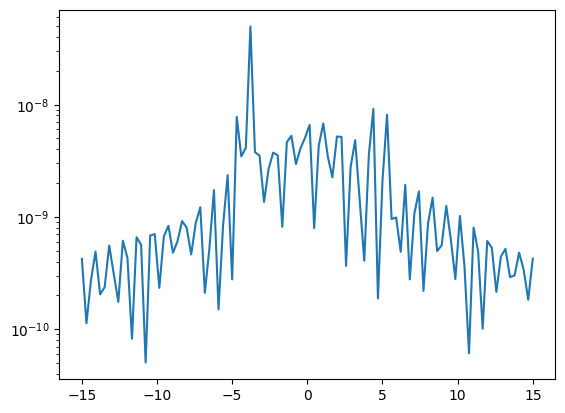

In [56]:
import matplotlib.pyplot as plt

x = np.linspace(-15, 15, 100)
y1 = []
y2 = []
N = []

a, b = 0.9, -1
c = 1 - a**2
for val_x in x:
    y1.append(f_F3Function_int_dawsn(val_x, a, b))
    y2.append(f_F3Function_series(val_x, a, b, 5, 0.4))

y1, y2 = np.asarray(y1), np.asarray(y2)

# plt.plot(x, y1)
# plt.plot(x, y2)
plt.plot(x, np.abs(y1-y2))
plt.yscale("log")

# print(x[np.argmax(np.abs(y1-y2))])

In [57]:
def calc_error(a, NMAX, h):
    max_error = 0
    for x in np.linspace(-15, 15, 100):
        for b in np.linspace(-10, 10, 10):
            error = f_F3Function_int_dawsn(x, a, b)-f_F3Function_series(x, a, b, NMAX, h)
            if np.abs(error) > max_error:
                max_error = np.abs(error)
    return max_error
    

In [58]:
# import datlib 

# N = np.arange(2, 15)
# error = []
# a = .9
# h = .4

# for n in N:
#     error.append(calc_error(a, n, h))

# plt.yscale("log")
# plt.plot(N, error)

# datlib.np2dat(
#     f"data/F3_error_a_{a}_h_{h}.dat",
#     "N err".split(),
#     np.asarray([
#         N, error
#     ])
# )

### Численный расчет

#### Определения

In [59]:
import Z2 as Z2_module

In [60]:
f_F3Function = f_F3Function_series

In [61]:
def _Z3_E_terms(h_i, h_j, l_ij, l_ik):
    result = np.zeros((2, 2, 2))
    for i1, s1 in enumerate(SIGMAS):
        for i2, s2 in enumerate(SIGMAS):
            for i3, s3 in enumerate(SIGMAS):
                arg = s3*h_j+s1*s2*l_ik+(s1+s2)*(h_i+s3*l_ij)
                result[i1, i2, i3] = np.exp(arg)
    return result

def _Z3_F3_terms(h_i, h_j, l_ij, l_ik):
    _arg1 = lambda s1, s2, s3: (h_i+s3*l_ij+(s1+s2)*h_i/h_j*l_ij)/np.sqrt(2*h_i/h_j*l_ij)
    _arg2 = np.sqrt(h_i/h_j*l_ij/l_ik)
    _arg3 = lambda s1, s2: (s1+s2)/np.sqrt(2*l_ik)*(l_ik-h_i/h_j*l_ij)
    result = np.zeros((2, 2, 2))
    for i1, s1 in enumerate(SIGMAS):
        for i2, s2 in enumerate(SIGMAS):
            for i3, s3 in enumerate(SIGMAS):
                args = _arg1(s1, s2, s3), _arg2, _arg3(s1, s2)
                result[i1, i2, i3] = f_F3Function(*args)
    return result

def _Z3_F_tilde_terms(h_i, h_j, l_ij, l_ik):
    result = np.zeros((2, 2, 2))
    for i1, s1 in enumerate(SIGMAS):
        for i2, s2 in enumerate(SIGMAS):
            for i3, s3 in enumerate(SIGMAS):
                arg = (h_i+s3*l_ij+(s1+s2)*l_ik)/np.sqrt(2*l_ik)
                result[i1, i2, i3] = f_F2Function(arg)
    return result

def _Z3_F_terms(h_i, h_j, l_ij, l_ik):
    result = np.zeros((2, 2, 2))
    for i1, s1 in enumerate(SIGMAS):
        for i2, s2 in enumerate(SIGMAS):
            for i3, s3 in enumerate(SIGMAS):
                arg = (h_i+s3*l_ij+(s1+s2)*h_i/h_j*l_ij)/np.sqrt(2*h_i/h_j*l_ij)
                result[i1, i2, i3] = f_F2Function(arg)
    return result

In [62]:
def _Z3_sum_terms(terms, sigmas_func):
    result = 0
    for i1, s1 in enumerate(SIGMAS):
        for i2, s2 in enumerate(SIGMAS):
            for i3, s3 in enumerate(SIGMAS):
                result += sigmas_func(s1, s2, s3)*terms[i1, i2, i3]
    return result

In [63]:
def f_cF3Function(h_i, h_j, l_ij, l_ik):
    _E_terms = _Z3_E_terms(h_i, h_j, l_ij, l_ik)
    _F3_terms = _Z3_F3_terms(h_i, h_j, l_ij, l_ik)
    
    _terms = _E_terms*_F3_terms
    _sigmas_func_123 = lambda s1, s2, s3: s1*s2*s3
   
    return _Z3_sum_terms(_terms, _sigmas_func_123)

In [64]:
def f_Z1(p):
    return 4*np.pi/p*np.sinh(p)

def raw_Z2(h, l):
    def _sqrt(x): return np.sqrt(h**2+l**2+2*h*l*x)
    def func(x): return np.exp(h*x)*f_Z1(_sqrt(x))
    return 2*np.pi*quad(func, -1, 1)[0]

In [65]:
def raw_Z3(h_i, h_j, l_ij, l_ik):
    _sqrt = lambda x: np.sqrt(h_i**2+l_ij**2+2*h_i*l_ij*x)
    func = lambda x: np.exp(h_j*x)*np.exp(2*_sqrt(x)+l_ik)*Z2_module.calc_Z2_norm(_sqrt(x), l_ik)
    return 2*np.pi*quad(func, -1, 1)[0]


def Z3(h_i, h_j, l_ij, l_ik):
    return 2*(2*np.pi)**3/np.sqrt(h_i*h_j*l_ij*l_ik)*f_cF3Function(h_i, h_j, l_ij, l_ik)

In [66]:
v_raw_Z3 = lambda x: raw_Z3(*x)
v_cF3 = lambda x: f_cF3Function(*x)
v_F3 = lambda x: f_F3Function(*x)

In [67]:
def f_EFunction(h_i, h_j, l_ij, l_ik, arg_s1, arg_s2, arg_s3):
    def _sigmas_func(s1, s2, s3):
        result = 1
        if arg_s1:
            result *= s1
        if arg_s2:
            result *= s2
        if arg_s3:
            result *= s3
        return result
    return _Z3_sum_terms(_Z3_E_terms(h_i, h_j, l_ij, l_ik), _sigmas_func)


def f_FTildeFunction(h_i, h_j, l_ij, l_ik, arg_s1, arg_s2, arg_s3):
    def _sigmas_func(s1, s2, s3):
        result = 1
        if arg_s1:
            result *= s1
        if arg_s2:
            result *= s2
        if arg_s3:
            result *= s3
        return result
    terms = _Z3_E_terms(h_i, h_j, l_ij, l_ik)*_Z3_F_tilde_terms(h_i, h_j, l_ij, l_ik)
    return _Z3_sum_terms(terms, _sigmas_func)


def f_FFunction(h_i, h_j, l_ij, l_ik, arg_s1, arg_s2, arg_s3):
    def _sigmas_func(s1, s2, s3):
        result = 1
        if arg_s1:
            result *= s1
        if arg_s2:
            result *= s2
        if arg_s3:
            result *= s3
        return result
    terms = _Z3_E_terms(h_i, h_j, l_ij, l_ik)*_Z3_F_terms(h_i, h_j, l_ij, l_ik)
    return _Z3_sum_terms(terms, _sigmas_func)


module_dictionary = {"cF3Function": f_cF3Function, "cF3Function_degenerate": f_cF3Function,
                     "EFunction": f_EFunction, 
                     "FTildeFunction": f_FTildeFunction, "FFunction": f_FFunction,
                     "F2Function": f_F2Function, "F3Function": f_F3Function}

module = [module_dictionary, "scipy"]

#### Проверка

In [68]:
args = 1.1, 1.4, 0.9, 1.2

print(raw_Z3(*args))
print(Z3(*args))

10617.721695485005
10617.721784912486


In [69]:
def get_diffs(expr, args, n=1, func=None):
    diffs = []
    for arg in args:
        _expr = expr.diff(arg, n)
        if func is not None:
            _expr = func(_expr)
        diffs.append(sp.lambdify(args, _expr, module))
    return diffs

In [70]:
def calc_numerical_diffs(func, args, n=1):
    diffs = np.zeros_like(args)
    for i, arg in enumerate(args):
        direction = [0] * len(args)
        direction[i] = 1
        diffs[i] = nd.directionaldiff(func, args, direction, n=n)
    return diffs


def calc_exprs(exprs, args):
    return list(map(lambda expr: expr(*args), exprs))


def compare_exprs(exprs_1, exprs_2):
    for i, expr in enumerate(exprs_1):
        print(expr)
        print(exprs_2[i])
        print()

In [71]:
x, a, b = abc.x, abc.a, abc.b

f_F3_diffs = get_diffs(F3Function(x, a, b), [x, a, b])

args = 1.4, -6, 3
compare_exprs(
    calc_numerical_diffs(v_F3, args),
    calc_exprs(f_F3_diffs, args)
)

0.03525288652015937
0.03525290451467536

-0.008072403402545697
-0.008072407295599701

-0.0005077315366300761
-0.0005077351306516653



In [72]:
f_F3_degenerate_diffs = get_diffs(F3Function_degenerate(x, a, b, 0, 0), [x, a, b], func=evaluate_F3Function_degenerate)

args = 1.4, 1, 0
compare_exprs(
    calc_numerical_diffs(v_F3, args),
    calc_exprs(f_F3_degenerate_diffs, args)
)

-0.1302029228678329
-0.13020292286800322

-0.03858026434738476
-0.0385803100027116

0.033499433211962616
0.03349943321073004



In [73]:
args = .1, 1000, 1000
f_F3Function(*args)/f_F2Function(args[0]*args[1]+args[2])/f_F2Function(args[0])

1.0483292404522935

In [74]:
expr = F3Function_degenerate(x, a, b, 0, 0).diff(x, x, a)
expr = evaluate_F3Function_degenerate(expr)
f_expr = sp.lambdify([x, a, b], expr, module)

args = 1.4, 1, 0
f = lambda args: nd.directionaldiff(v_F3, args, [1, 0, 0], n=2)
print(nd.directionaldiff(f, args, [0, 1, 0], n=1))
print(f_expr(*args))

0.39949391897786524
0.3994973376239892


In [75]:
args_coeffs = h_i, h_j, l_ij, l_ik

In [76]:
f_E_123 = sp.lambdify(args_coeffs, EFunction(*args_coeffs, 1, 1, 1), module)
f_E_123_diffs = get_diffs(EFunction(*args_coeffs, 1, 1, 1), args_coeffs)
v_f_E_123 = lambda x: f_E_123(*x)

args = 1.1, 1.6, 0.9, 1.2
compare_exprs(
    calc_numerical_diffs(v_f_E_123, args),
    calc_exprs(f_E_123_diffs, args)
)

1793.9908528051935
1793.9908528052451

896.4925453059092
896.4925453059141

1796.193536948808
1796.1935369487762

899.5611861682389
899.5611861682446



In [77]:
f_expr = sp.lambdify(args_coeffs, EFunction(*args_coeffs, 1, 1, 1).rewrite(sp.exp), module)

args = 1.1, 1.9, 0.9, 1.2
print(f_expr(*args))
print(f_E_123(*args))

1207.3625478377833
1207.3625478377833


In [78]:
f_F_123 = sp.lambdify(args_coeffs, FFunction(*args_coeffs, 1, 1, 1), module)
f_F_123_diffs = get_diffs(FFunction(*args_coeffs, 1, 1, 1), args_coeffs)
v_f_F_123 = lambda x: f_F_123(*x)

args = 1.0, 1.6, 0.9, 1.2
compare_exprs(
    calc_numerical_diffs(v_f_F_123, args),
    calc_exprs(f_F_123_diffs, args)
)

242.96196215703418
242.9619621570704

125.49170030046874
125.49170030046551

247.56814708557008
247.56814708556857

140.24587304244235
140.2458730424406



In [79]:
f_expr = sp.lambdify(args_coeffs, FFunction(*args_coeffs, 1, 1, 1).rewrite(sp.exp), module)

args = 1.1, 1.9, 0.9, 1.5
print(f_expr(*args))
print(f_F_123(*args))

293.0672473277535
293.0672473277536


In [80]:
f_F_tilde_123 = sp.lambdify(args_coeffs, FTildeFunction(*args_coeffs, 1, 1, 1), module)
f_F_tilde_123_diffs = get_diffs(FTildeFunction(*args_coeffs, 1, 1, 1), args_coeffs)
v_f_F_tilde_123 = lambda x: f_F_tilde_123(*x)

args = 1.1, 1.6, 0.9, 1.3
compare_exprs(
    calc_numerical_diffs(v_f_F_tilde_123, args),
    calc_exprs(f_F_tilde_123_diffs, args)
)

326.37914592414165
326.37914592413733

186.48747756171457
186.4874775617166

328.17606098362404
328.1760609836284

176.9750210485126
176.97502104854397



In [81]:
f_expr = sp.lambdify(args_coeffs, FTildeFunction(*args_coeffs, 1, 1, 1).rewrite(sp.exp), module)

args = 1.1, 1.9, 0.9, 1.9
print(f_expr(*args))
print(f_F_tilde_123(*args))

437.6062993441376
437.6062993441372


In [82]:
f_cF3_diffs = get_diffs(cF3Function(*args_coeffs), args_coeffs)

args = 1.1, 1.6, 0.9, 1.2
compare_exprs(
    calc_numerical_diffs(v_cF3, args),
    calc_exprs(f_cF3_diffs, args)
)

50.18657854789748
50.186555067739306

29.615695187963986
29.615693179348234

51.58742020605026
51.58739746917982

31.113111031705216
31.11310492592588



In [83]:
f_expr = sp.lambdify(args_coeffs, cF3Function(*args_coeffs).rewrite(sp.exp), module)

args = 1.1, 1.9, 0.9, 1.6
print(f_expr(*args))
print(f_cF3Function(*args))

62.3891806479837
62.38918064798398


In [84]:
f_cF3_degenerate_diffs = get_diffs(cF3Function_degenerate(*args_coeffs, *(4*[0])), args_coeffs, n=1, func=evaluate_cF3Function_degenerate)

args = 1, 2, 2., 1
compare_exprs(
    calc_numerical_diffs(v_cF3, args, n=1),
    calc_exprs(f_cF3_degenerate_diffs, args)
)

314.13163388750917
314.1315377891452

173.2568386238233
173.2568552898068

299.8757416784606
299.87564461287616

203.7037525130895
203.70383486131095



## Моменты $\cal Z^{(3)}$

### Определения

In [86]:
def get_line_Matrix(expr, like_terms):
    terms = sp.collect(expr, like_terms, evaluate=False)
    line = []
    for term in like_terms + [1]:
        if term in terms:
            if term == 1:
                line.append(-terms[term].factor())
            else:
                line.append(terms[term].factor())
        else:
            line.append(0)
    return line


### Общий случай

#### Символьные вычисления

In [87]:
m_i = sp.Symbol("\\left<{m_i}\\right>")
m_j = sp.Symbol("\\left<{m_j}\\right>")
eta_ij = sp.Symbol("\\left<{\\eta_{ij}}\\right>")
eta_ik = sp.Symbol("\\left<{\\eta_{ik}}\\right>")

In [88]:
Z3_expr = cF3Function(h_i, h_j, l_ij, l_ik)/sp.sqrt(h_i*h_j*l_ij*l_ik)

expr_m_i = sp.log(Z3_expr).diff(h_i)/2
expr_m_i = sp.Add(*map(sp.factor, expr_m_i.expand().args))

expr_m_j = sp.log(Z3_expr).diff(h_j)
expr_m_j = sp.Add(*map(sp.factor, expr_m_j.expand().args))

expr_eta_ij = sp.log(Z3_expr).diff(l_ij)/2
expr_eta_ij = sp.Add(*map(sp.factor, expr_eta_ij.expand().args))

expr_eta_ik = sp.log(Z3_expr).diff(l_ik)
expr_eta_ik = sp.Add(*map(sp.factor, expr_eta_ik.expand().args))

In [89]:
n, d = sp.fraction(expr_m_i.factor())
_expr_m_i = n-d*m_i

n, d = sp.fraction(expr_m_j.factor())
_expr_m_j = n-d*m_j

n, d = sp.fraction(expr_eta_ij.factor())
_expr_eta_ij = n-d*eta_ij

n, d = sp.fraction(expr_eta_ik.factor())
_expr_eta_ik = n-d*eta_ik

In [90]:
vector_system_moments = [
    cF3Function(h_i, h_j, l_ij, l_ik),
    FTildeFunction(h_i, h_j, l_ij, l_ik, 1, 1, 1),
    FTildeFunction(h_i, h_j, l_ij, l_ik, 1, 1, 0),
    FFunction(h_i, h_j, l_ij, l_ik, 1, 0, 1),
]

line1 = get_line_Matrix(_expr_m_i, vector_system_moments)
line2 = get_line_Matrix(_expr_m_j, vector_system_moments)
line3 = get_line_Matrix(_expr_eta_ij, vector_system_moments)
line4 = get_line_Matrix(_expr_eta_ik, vector_system_moments)

In [91]:
M = sp.Matrix([line1, line2, line3, line4])
M[0, :] /= sp.sqrt(l_ij)*h_i*sp.sqrt(h_i)/sp.sqrt(h_j)
M[1, :] /= sp.sqrt(l_ij)*sp.sqrt(h_i)
M[2, :] /= sp.sqrt(l_ij)*l_ij*sp.sqrt(h_i)/sp.sqrt(h_j)
M[3, :] /= sp.sqrt(l_ik)/sp.sqrt(h_j)

M[0, :] += M[1, :]
M[1, :] += M[2, :]
M[2, :] += M[0, :]/2
M[2, :] -= M[1, :]
M[2, :] += l_ik*h_j*M[3, :]
M[3, :] -= M[2, :]/(l_ik*h_j)
M = M.expand()

M = sp.Matrix(4, 5, lambda i, j: M[i, j].factor())
M[0, :] /= (l_ij*h_i-l_ik*h_j)*h_i*sp.sqrt(h_j)*2
M[1, :] /= (l_ij*h_i-l_ik*h_j)*l_ij*sp.sqrt(h_j)*2
M[2, :] /= (l_ij*h_i-l_ik*h_j)*sp.sqrt(h_j)
M[3, :] *= l_ik*sp.sqrt(h_j)

M[2, :] -= M[0, :]*h_i
M[3, :] += M[0, :]*h_i**2*l_ij
M[3, :] += M[1, :]*h_j*l_ij*l_ik
M[2, :] += M[3, :]/(h_i*l_ij)
M[3, :] += M[2, :]/(l_ik*h_j)*h_i**2*l_ij**2
M = M.expand()

M = sp.Matrix(4, 5, lambda i, j: M[i, j].factor())
M[0, :] /= -2
M[1, :] /= -2
M[2, :] /= -2*l_ik*h_j
M[3, :] /= -2*l_ij*h_i

det_system_moments = sp.Symbol("\\Delta")
det_system_moments_value = M[3, 0]
M[3, 0] = det_system_moments

display(M)

Matrix([
[                             2*\lambda_{ij}*\left<{m_i}\right>*h_i + \lambda_{ij}*\left<{m_j}\right>*h_j + \lambda_{ij} + h_i*h_j, -sqrt(2)*sqrt(\lambda_{ij})*sqrt(h_i)*sqrt(h_j)/2,                                                 0,                           0,                                                                                                                    0],
[                                2*\lambda_{ij}*\left<{\eta_{ij}}\right>*h_i + \lambda_{ij}*h_j + \left<{m_j}\right>*h_i*h_j + h_i,                                                 0, -sqrt(2)*sqrt(\lambda_{ij})*sqrt(h_i)*sqrt(h_j)/2,                           0,                                                                                                                    0],
[2*\lambda_{ij}*\left<{\eta_{ij}}\right> + 2*\lambda_{ik}*\left<{\eta_{ik}}\right> + 2*\lambda_{ik} + 2*\left<{m_i}\right>*h_i + 2,                                                 0,                                             

In [92]:
det_system_moments_value.collect([m_i, m_j, eta_ij, eta_ik], sp.factor)

\lambda_{ij}**2*h_j + 2*\lambda_{ij}*\lambda_{ik}*\left<{\eta_{ik}}\right>*h_i + 2*\lambda_{ij}*\lambda_{ik}*h_i + 2*\lambda_{ij}*\left<{\eta_{ij}}\right>*(\lambda_{ij}*h_i + \lambda_{ik}*h_j) + 2*\lambda_{ij}*\left<{m_j}\right>*h_i*h_j + 2*\lambda_{ij}*h_i + \lambda_{ik}*h_j + 2*\left<{m_i}\right>*h_i*(\lambda_{ij}*h_i + \lambda_{ik}*h_j) + h_i**2*h_j

In [93]:
result = sp.solve_linear_system(M, *vector_system_moments)

value_system_moments = []
for key in vector_system_moments:
    value_system_moments.append(result[key].factor())

for i in range(4):
    display(sp.Eq(vector_system_moments[i], value_system_moments[i]))
for i in range(4):
    sp.print_latex(sp.Eq(vector_system_moments[i], value_system_moments[i]))

display(sp.Eq(det_system_moments, det_system_moments_value))
sp.print_latex(sp.Eq(det_system_moments, det_system_moments_value))

Eq(cF3Function(h_i, h_j, \lambda_{ij}, \lambda_{ik}), sqrt(\lambda_{ij})*sqrt(\lambda_{ik})*sqrt(h_i)*sqrt(h_j)*EFunction(h_i, h_j, \lambda_{ij}, \lambda_{ik}, 1, 1, 1)/(2*\Delta))

Eq(FTildeFunction(h_i, h_j, \lambda_{ij}, \lambda_{ik}, 1, 1, 1), sqrt(2)*sqrt(\lambda_{ik})*(2*\lambda_{ij}*\left<{m_i}\right>*h_i + \lambda_{ij}*\left<{m_j}\right>*h_j + \lambda_{ij} + h_i*h_j)*EFunction(h_i, h_j, \lambda_{ij}, \lambda_{ik}, 1, 1, 1)/(2*\Delta))

Eq(FTildeFunction(h_i, h_j, \lambda_{ij}, \lambda_{ik}, 1, 1, 0), sqrt(2)*sqrt(\lambda_{ik})*(2*\lambda_{ij}*\left<{\eta_{ij}}\right>*h_i + \lambda_{ij}*h_j + \left<{m_j}\right>*h_i*h_j + h_i)*EFunction(h_i, h_j, \lambda_{ij}, \lambda_{ik}, 1, 1, 1)/(2*\Delta))

Eq(FFunction(h_i, h_j, \lambda_{ij}, \lambda_{ik}, 1, 0, 1), sqrt(2)*sqrt(\lambda_{ij})*sqrt(h_i)*sqrt(h_j)*(\lambda_{ij}*\left<{\eta_{ij}}\right> + \lambda_{ik}*\left<{\eta_{ik}}\right> + \lambda_{ik} + \left<{m_i}\right>*h_i + 1)*EFunction(h_i, h_j, \lambda_{ij}, \lambda_{ik}, 1, 1, 1)/(2*\Delta))

{\cal F}^{(3)}\left(h_{i}, h_{j}, \lambda_{ij}, \lambda_{ik}\right) = \frac{\sqrt{\lambda_{ij}} \sqrt{\lambda_{ik}} \sqrt{h_{i}} \sqrt{h_{j}} {\cal E}_{123}\left(h_{i}, h_{j}, \lambda_{ij}, \lambda_{ik}\right)}{2 \Delta}
\tilde{\cal F}_{123}\left(h_{i}, h_{j}, \lambda_{ij}, \lambda_{ik}\right) = \frac{\sqrt{2} \sqrt{\lambda_{ik}} \left(2 \lambda_{ij} \left<{m_i}\right> h_{i} + \lambda_{ij} \left<{m_j}\right> h_{j} + \lambda_{ij} + h_{i} h_{j}\right) {\cal E}_{123}\left(h_{i}, h_{j}, \lambda_{ij}, \lambda_{ik}\right)}{2 \Delta}
\tilde{\cal F}_{12}\left(h_{i}, h_{j}, \lambda_{ij}, \lambda_{ik}\right) = \frac{\sqrt{2} \sqrt{\lambda_{ik}} \left(2 \lambda_{ij} \left<{\eta_{ij}}\right> h_{i} + \lambda_{ij} h_{j} + \left<{m_j}\right> h_{i} h_{j} + h_{i}\right) {\cal E}_{123}\left(h_{i}, h_{j}, \lambda_{ij}, \lambda_{ik}\right)}{2 \Delta}
{\cal F}_{13}\left(h_{i}, h_{j}, \lambda_{ij}, \lambda_{ik}\right) = \frac{\sqrt{2} \sqrt{\lambda_{ij}} \sqrt{h_{i}} \sqrt{h_{j}} \left(\lambda_{ij} \left<{\

Eq(\Delta, 2*\lambda_{ij}**2*\left<{\eta_{ij}}\right>*h_i + \lambda_{ij}**2*h_j + 2*\lambda_{ij}*\lambda_{ik}*\left<{\eta_{ij}}\right>*h_j + 2*\lambda_{ij}*\lambda_{ik}*\left<{\eta_{ik}}\right>*h_i + 2*\lambda_{ij}*\lambda_{ik}*h_i + 2*\lambda_{ij}*\left<{m_i}\right>*h_i**2 + 2*\lambda_{ij}*\left<{m_j}\right>*h_i*h_j + 2*\lambda_{ij}*h_i + 2*\lambda_{ik}*\left<{m_i}\right>*h_i*h_j + \lambda_{ik}*h_j + h_i**2*h_j)

\Delta = 2 \lambda_{ij}^{2} \left<{\eta_{ij}}\right> h_{i} + \lambda_{ij}^{2} h_{j} + 2 \lambda_{ij} \lambda_{ik} \left<{\eta_{ij}}\right> h_{j} + 2 \lambda_{ij} \lambda_{ik} \left<{\eta_{ik}}\right> h_{i} + 2 \lambda_{ij} \lambda_{ik} h_{i} + 2 \lambda_{ij} \left<{m_i}\right> h_{i}^{2} + 2 \lambda_{ij} \left<{m_j}\right> h_{i} h_{j} + 2 \lambda_{ij} h_{i} + 2 \lambda_{ik} \left<{m_i}\right> h_{i} h_{j} + \lambda_{ik} h_{j} + h_{i}^{2} h_{j}


In [94]:
subs_to_moments = dict(zip(vector_system_moments, value_system_moments))
subs_det_system_moments = {det_system_moments: det_system_moments_value}

In [95]:
expr = expr_eta_ik
expr.subs(subs_to_moments).subs(subs_det_system_moments).factor()

\left<{\eta_{ik}}\right>

In [96]:
expr_Q_star = Z3_expr.diff(l_ij, 2)/(2*Z3_expr) - expr_eta_ik - 1
expr_Q_star = sp.Add(*map(sp.factor, expr_Q_star.expand().args))
# expr_Q_star

In [97]:
expr_diff_h_i_l_ij = Z3_expr.diff(h_i, l_ij)/(Z3_expr)
expr_diff_h_i_l_ij = sp.Add(*map(sp.factor, expr_diff_h_i_l_ij.expand().args))
expr_diff_h_i_l_ij = expr_diff_h_i_l_ij.subs(subs_to_moments)

expr_m_j_eta_ij = Z3_expr.diff(h_j, l_ij)/(2*Z3_expr)
expr_m_j_eta_ij = sp.Add(*map(sp.factor, expr_m_j_eta_ij.expand().args))
expr_m_j_eta_ij = expr_m_j_eta_ij.subs(subs_to_moments)

expr_m_i_eta_ik = Z3_expr.diff(h_i, l_ik)/(2*Z3_expr)
expr_m_i_eta_ik = sp.Add(*map(sp.factor, expr_m_i_eta_ik.expand().args))
expr_m_i_eta_ik = expr_m_i_eta_ik.subs(subs_to_moments)

expr_eta_ik_2 = Z3_expr.diff(l_ik, 2)/(Z3_expr)
expr_eta_ik_2 = sp.Add(*map(sp.factor, expr_eta_ik_2.expand().args))
expr_eta_ik_2 = expr_eta_ik_2.subs(subs_to_moments)

In [98]:
eta_ik_2 = sp.Symbol("\\left<\eta_{ik}^{2}\\right>")
m_j_eta_ij = sp.Symbol("\\left<m_j\\eta_{ij}\\right>")
m_i_eta_ik = sp.Symbol("\\left<m_i\\eta_{ik}\\right>")

In [99]:
factor = (l_ij*h_i-l_ik*h_j)**2

expr1 = (expr_diff_h_i_l_ij.factor()*factor).expand() - factor*sp.Dummy()
expr2 = (expr_m_j_eta_ij.factor()*factor).expand() - factor*m_j_eta_ij
expr3 = (expr_m_i_eta_ik.factor()*factor).expand() - factor*m_i_eta_ik
expr4 = (expr_eta_ik_2.factor()*factor).expand() - factor*eta_ik_2

In [100]:
vector_system_moments_2 = [
    EFunction(*args_coeffs, 0, 0, 1)/EFunction(*args_coeffs, 1, 1, 1),
    EFunction(*args_coeffs, 1, 0, 0)/EFunction(*args_coeffs, 1, 1, 1),
    EFunction(*args_coeffs, 1, 1, 0)/EFunction(*args_coeffs, 1, 1, 1),
    EFunction(*args_coeffs, 1, 0, 1)/EFunction(*args_coeffs, 1, 1, 1),
]

line1 = get_line_Matrix(expr1, vector_system_moments_2)
line2 = get_line_Matrix(expr2, vector_system_moments_2)
line3 = get_line_Matrix(expr3, vector_system_moments_2)
line4 = get_line_Matrix(expr4, vector_system_moments_2)

In [101]:
M = sp.Matrix([line1, line2, line3, line4])
M = M.expand()

M[0, :] += M[1, :]*2/h_i*h_j
M[1, :] -= M[2, :]*h_i**2/h_j**2
M[2, :] += M[3, :]/2/h_i*l_ik
M[3, :] += M[2, :]*2*h_i/l_ik

M = M.expand()

display(M)

Matrix([
[                                                      0,                                                                                                                  0,                                                                  \Delta*\lambda_{ij}*h_i/\lambda_{ik} - 2*\Delta*h_j + \Delta*\lambda_{ik}*h_j**2/(\lambda_{ij}*h_i),                                                                                                                  0,                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        

In [102]:
value_system_moments_2 = []

result = (M[:, :-1]).solve(M[:, -1])
for item in result:
    value_system_moments_2.append(item.factor())

# for i in range(4):
#     display(sp.Eq(vector_system_moments_2[i], value_system_moments_2[i]))
# for i in range(4):
#     sp.print_latex(sp.Eq(vector_system_moments_2[i], value_system_moments_2[i]))

In [103]:
subs_to_moments_2 = dict(zip(vector_system_moments_2, value_system_moments_2))

In [104]:
expr_Q_star_from_m_j_eta_ij = expr_Q_star.subs(subs_to_moments).subs(subs_to_moments_2).subs(subs_det_system_moments).factor().expand()
display(expr_Q_star_from_m_j_eta_ij)
sp.print_latex((l_ij*expr_Q_star_from_m_j_eta_ij).expand())

-\left<m_j\eta_{ij}\right>*h_j/\lambda_{ij} - 2*\left<{\eta_{ij}}\right>/\lambda_{ij} + \left<{m_i}\right>*h_j/\lambda_{ij}

- \left<m_j\eta_{ij}\right> h_{j} - 2 \left<{\eta_{ij}}\right> + \left<{m_i}\right> h_{j}


In [105]:
expr_m_j_par_2 = Z3_expr.diff(h_j, 2)/(Z3_expr)
expr_m_j_par_2 = sp.Add(*map(sp.factor, expr_m_j_par_2.expand().args))
expr = expr_m_j_par_2.subs(subs_to_moments).subs(subs_to_moments_2).subs(subs_det_system_moments).factor().expand()

m_j_par_2 = sp.Symbol("\\left<m_{jh}^2\\right>")
display(sp.Eq(m_j_par_2, expr))
sp.print_latex(expr)
 
expr_Q_star_from_m_2_par_2 = expr_Q_star_from_m_j_eta_ij.replace(m_j_eta_ij, sp.solve(expr-m_j_par_2, m_j_eta_ij)[0]).expand()
display(expr_Q_star_from_m_2_par_2)
sp.print_latex((l_ij*expr_Q_star_from_m_2_par_2).expand())

_expr_m_j_par_2 = expr

Eq(\left<m_{jh}^2\right>, -2*\lambda_{ij}*\left<m_j\eta_{ij}\right>/h_j + 2*\lambda_{ij}*\left<{m_i}\right>/h_j - 2*\left<{m_j}\right>/h_j + 1)

- \frac{2 \lambda_{ij} \left<m_j\eta_{ij}\right>}{h_{j}} + \frac{2 \lambda_{ij} \left<{m_i}\right>}{h_{j}} - \frac{2 \left<{m_j}\right>}{h_{j}} + 1


-2*\left<{\eta_{ij}}\right>/\lambda_{ij} + \left<m_{jh}^2\right>*h_j**2/(2*\lambda_{ij}**2) + \left<{m_j}\right>*h_j/\lambda_{ij}**2 - h_j**2/(2*\lambda_{ij}**2)

- 2 \left<{\eta_{ij}}\right> + \frac{\left<m_{jh}^2\right> h_{j}^{2}}{2 \lambda_{ij}} + \frac{\left<{m_j}\right> h_{j}}{\lambda_{ij}} - \frac{h_{j}^{2}}{2 \lambda_{ij}}


In [106]:
expr_m_j_eta_ik = Z3_expr.diff(h_j, l_ik)/(Z3_expr)
expr_m_j_eta_ik = sp.Add(*map(sp.factor, expr_m_j_eta_ik.expand().args))
expr = expr_m_j_eta_ik.subs(subs_to_moments).subs(subs_to_moments_2).subs(subs_det_system_moments).factor().expand()

m_j_eta_ik = sp.Symbol("\\left<{m_2\\eta_2}\\right>")
display(sp.Eq(m_j_eta_ik, expr))

Eq(\left<{m_2\eta_2}\right>, _Dummy_798/2 - \left<m_j\eta_{ij}\right>*h_j/h_i + \left<{m_i}\right>*h_j/h_i - \left<{m_j}\right>)

#### Проверка

In [107]:
args_moments = h_i, h_j, l_ij, l_ik, m_i, m_j, eta_ij, eta_ik

In [108]:
f_expr_m_i = sp.lambdify(args_coeffs, expr_m_i, module)
f_expr_m_j = sp.lambdify(args_coeffs, expr_m_j, module)
f_expr_eta_ij = sp.lambdify(args_coeffs, expr_eta_ij, module)
f_expr_eta_ik = sp.lambdify(args_coeffs, expr_eta_ik, module)

args = 1.4, 1.1, 0.9, 1.2
compare_exprs(
    calc_numerical_diffs(v_raw_Z3, args)/(np.asarray([2, 1, 2, 1])*v_raw_Z3(args)),
    calc_exprs([f_expr_m_i, f_expr_m_j, f_expr_eta_ij, f_expr_eta_ik], args)
)

0.575477601688201
0.5754779493045652

0.5237828164508116
0.5237813820122512

0.49566723243071426
0.49566789130909583

0.5488518559086166
0.5488505334644458



/tmp/ipykernel_2837517/3652816044.py:4: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  return 2*np.pi*quad(func, -1, 1)[0]


In [109]:
args = 2, 1, 1.1, 1.4
moments = f_expr_m_i(*args), f_expr_m_j(*args), f_expr_eta_ij(*args), f_expr_eta_ik(*args)

for i in range(4):
    left = vector_system_moments[i].subs(subs_det_system_moments)
    f_left = sp.lambdify(args_moments, left, module)
    print(f_left(*args, *moments))

    right = value_system_moments[i].subs(subs_det_system_moments)
    f_right = sp.lambdify(args_moments, right, module)
    print(f_right(*args, *moments))

    print()

125.39966446986146
125.39966446986132

803.4785804726862
803.4785804726858

807.8020766568538
807.8020766568538

791.6950105075871
791.6950105075873



In [110]:
f_expr_Q_star = sp.lambdify(args_coeffs, expr_Q_star, module)

args = 0.2073412, 0.13806503, 1.26262682, 0.15322752
Q_star = nd.directionaldiff(v_raw_Z3, args, [0, 0, 1, 0], n=2)/(2*v_raw_Z3(args)) - f_expr_eta_ik(*args) - 1
print(Q_star)
print(f_expr_Q_star(*args))

moments = f_expr_m_i(*args), f_expr_m_j(*args), f_expr_eta_ij(*args), f_expr_eta_ik(*args)

f_expr_Q_star_from_m_j_eta_ij = sp.lambdify(list(args_moments) + [m_j_eta_ij], expr_Q_star_from_m_j_eta_ij, module)
f_expr_m_j_eta_ij = sp.lambdify(args_moments, expr_m_j_eta_ij.subs(subs_det_system_moments), module)
print(f_expr_Q_star_from_m_j_eta_ij(*args, *moments, f_expr_m_j_eta_ij(*args, *moments)))

f_expr_Q_star_from_m_j_par_2 = sp.lambdify(list(args_moments) + [m_j_par_2], expr_Q_star_from_m_2_par_2, module)
f_expr_m_j_par_2 = sp.lambdify(args_moments, expr_m_j_par_2.subs(subs_det_system_moments), module)
print(f_expr_Q_star_from_m_j_par_2(*args, *moments, f_expr_m_j_par_2(*args, *moments)))

-0.6289024238848074
-0.6289024102511016
-0.628902410251103
-0.6289024102511022


### Вырожденный случай

#### Символьные вычисления

In [111]:
_expr = cF3Function_degenerate(h_i, h_j, l_ij, l_ik, *(4*[0]))

subs_to_cF3Function_degenerate = {
    EFunction(h_i, h_j, l_ij, l_ik, 1, 1, 1): sp.solve(_expr-evaluate_cF3Function_degenerate(_expr), EFunction(h_i, h_j, l_ij, l_ik, 1, 1, 1))[0]
}

In [112]:
Z3_degenerate_expr = cF3Function_degenerate(h_i, h_j, l_ij, l_ik, *(4*[0]))/sp.sqrt(h_i*h_j*l_ij*l_ik)

In [113]:
expr_m_i_degenerate = sp.log(Z3_degenerate_expr).diff(h_i)/2
expr_m_i_degenerate = expr_m_i_degenerate.expand()
expr_m_i_degenerate = evaluate_cF3Function_degenerate(expr_m_i_degenerate)
expr_m_i_degenerate = expr_m_i_degenerate.subs(subs_to_cF3Function_degenerate).expand()

expr_m_j_degenerate = sp.log(Z3_degenerate_expr).diff(h_j)
expr_m_j_degenerate = expr_m_j_degenerate.expand()
expr_m_j_degenerate = evaluate_cF3Function_degenerate(expr_m_j_degenerate)
expr_m_j_degenerate = expr_m_j_degenerate.subs(subs_to_cF3Function_degenerate).expand()

expr_eta_ij_degenerate = sp.log(Z3_degenerate_expr).diff(l_ij)/2
expr_eta_ij_degenerate = expr_eta_ij_degenerate.expand()
expr_eta_ij_degenerate = evaluate_cF3Function_degenerate(expr_eta_ij_degenerate)
expr_eta_ij_degenerate = expr_eta_ij_degenerate.subs(subs_to_cF3Function_degenerate).expand()

expr_eta_ik_degenerate = sp.log(Z3_degenerate_expr).diff(l_ik)
expr_eta_ik_degenerate = expr_eta_ik_degenerate.expand()
expr_eta_ik_degenerate = evaluate_cF3Function_degenerate(expr_eta_ik_degenerate)
expr_eta_ik_degenerate = expr_eta_ik_degenerate.subs(subs_to_cF3Function_degenerate).expand()

In [114]:
n, d = sp.fraction(expr_m_i_degenerate.factor())
_expr_m_i = (n-d*m_i).expand()

n, d = sp.fraction(expr_m_j_degenerate.factor())
_expr_m_j = (n-d*m_j).expand()

n, d = sp.fraction(expr_eta_ij_degenerate.factor())
_expr_eta_1 = (n-d*eta_ij).expand()

n, d = sp.fraction(expr_eta_ik_degenerate.factor())
_expr_eta_2 = (n-d*eta_ik).expand()

In [115]:
vector_system_moments_degenerate = [
    FFunction(h_i, h_j, l_ij, l_ik, 1, 1, 0),
    FFunction(h_i, h_j, l_ij, l_ik, 1, 0, 1),
    FFunction(h_i, h_j, l_ij, l_ik, 1, 1, 1),
    cF3Function_degenerate(h_i, h_j, l_ij, l_ik, *(4*[0])),
]

line1 = get_line_Matrix(_expr_m_i, vector_system_moments_degenerate)
line2 = get_line_Matrix(_expr_m_j, vector_system_moments_degenerate)
line3 = get_line_Matrix(_expr_eta_1, vector_system_moments_degenerate)
line4 = get_line_Matrix(_expr_eta_2, vector_system_moments_degenerate)

In [116]:
M = sp.Matrix([line1, line2, line3, line4])
M = M.replace(l_ik, l_ij*h_i/h_j)

M[0, :] /= (2*h_i**3*h_j**2*l_ij**2)
M[1, :] /= (2*h_i**2*h_j**3*l_ij)
M[2, :] /= (2*h_i*h_j**2*l_ij**2)
M[3, :] /= (2*h_i**2*l_ij**2)

M[0, :] += M[1, :]/l_ij
M[1, :] += M[2, :]/h_i
M[2, :] += M[3, :]/h_j

M = M.expand()

A_system_moments_degenerate = sp.Symbol("A")
A_system_moments_degenerate_value = (M[3, 4]/(l_ij*h_i*h_j)).expand()
M[3, 4] = A_system_moments_degenerate*(l_ij*h_i*h_j)

display(M)
display(A_system_moments_degenerate_value)
sp.print_latex(A_system_moments_degenerate_value)

Matrix([
[                                                                                                                                                         0,                                                                                                                                                                                                              0,                                                                                                          3*sqrt(2)*sqrt(h_i)*h_j**(3/2)/sqrt(\lambda_{ij}),                                                                                                          -12*\left<{m_i}\right>*h_i*h_j - 6*\left<{m_j}\right>*h_j**2 - 6*h_j - 6*h_i*h_j**2/\lambda_{ij},                      0],
[                                                                                                        3*sqrt(2)*\lambda_{ij}**(3/2)*h_j**(3/2)/sqrt(h_i),                                                                                      

\lambda_{ij}*h_i*EFunction(h_i, h_j, \lambda_{ij}, \lambda_{ij}*h_i/h_j, 0, 0, 1) - \lambda_{ij}*h_j*EFunction(h_i, h_j, \lambda_{ij}, \lambda_{ij}*h_i/h_j, 1, 0, 0) - h_i*h_j*EFunction(h_i, h_j, \lambda_{ij}, \lambda_{ij}*h_i/h_j, 1, 0, 1) + h_j**2*EFunction(h_i, h_j, \lambda_{ij}, \lambda_{ij}*h_i/h_j, 1, 1, 0)

\lambda_{ij} h_{i} {\cal E}_{3}\left(h_{i}, h_{j}, \lambda_{ij}, \frac{\lambda_{ij} h_{i}}{h_{j}}\right) - \lambda_{ij} h_{j} {\cal E}_{1}\left(h_{i}, h_{j}, \lambda_{ij}, \frac{\lambda_{ij} h_{i}}{h_{j}}\right) - h_{i} h_{j} {\cal E}_{13}\left(h_{i}, h_{j}, \lambda_{ij}, \frac{\lambda_{ij} h_{i}}{h_{j}}\right) + h_{j}^{2} {\cal E}_{12}\left(h_{i}, h_{j}, \lambda_{ij}, \frac{\lambda_{ij} h_{i}}{h_{j}}\right)


In [117]:
vector_system_moments_degenerate = list(map(lambda item: item.replace(l_ik, l_ij*h_i/h_j), vector_system_moments_degenerate))

result = sp.solve_linear_system(M, *vector_system_moments_degenerate)

value_system_moments_degenerate = []
for key in vector_system_moments_degenerate:
    value_system_moments_degenerate.append(result[key].factor())

n, d = sp.fraction(value_system_moments_degenerate[0])
det_system_moments_degenerate_value = d/2
det_system_moments_degenerate = sp.Symbol("\\Delta")
subs_det_system_moments_degenerate = {det_system_moments_degenerate: det_system_moments_degenerate_value}

value_system_moments_degenerate = list(map(lambda item: item.subs(det_system_moments_degenerate_value, det_system_moments_degenerate), value_system_moments_degenerate))

for i in range(4):
    display(sp.Eq(vector_system_moments_degenerate[i], value_system_moments_degenerate[i]))
for i in range(4):
    sp.print_latex(sp.Eq(vector_system_moments_degenerate[i], value_system_moments_degenerate[i]))

display(sp.Eq(det_system_moments_degenerate, det_system_moments_degenerate_value))
sp.print_latex(sp.Eq(det_system_moments_degenerate, det_system_moments_degenerate_value))

Eq(FFunction(h_i, h_j, \lambda_{ij}, \lambda_{ij}*h_i/h_j, 1, 1, 0), -sqrt(2)*A*sqrt(\lambda_{ij})*sqrt(h_i)*sqrt(h_j)*(2*\lambda_{ij}*\left<{\eta_{ij}}\right>*h_i + \lambda_{ij}*h_j + \left<{m_j}\right>*h_i*h_j + h_i)/(2*\Delta))

Eq(FFunction(h_i, h_j, \lambda_{ij}, \lambda_{ij}*h_i/h_j, 1, 0, 1), -sqrt(2)*A*sqrt(\lambda_{ij})*sqrt(h_i)*sqrt(h_j)*(\lambda_{ij}*\left<{\eta_{ij}}\right>*h_j + \lambda_{ij}*\left<{\eta_{ik}}\right>*h_i + \lambda_{ij}*h_i + \left<{m_i}\right>*h_i*h_j + h_j)/(2*\Delta))

Eq(FFunction(h_i, h_j, \lambda_{ij}, \lambda_{ij}*h_i/h_j, 1, 1, 1), -sqrt(2)*A*sqrt(\lambda_{ij})*sqrt(h_i)*sqrt(h_j)*(2*\lambda_{ij}*\left<{m_i}\right>*h_i + \lambda_{ij}*\left<{m_j}\right>*h_j + \lambda_{ij} + h_i*h_j)/(2*\Delta))

Eq(cF3Function_degenerate(h_i, h_j, \lambda_{ij}, \lambda_{ij}*h_i/h_j, 0, 0, 0, 0), -A*\lambda_{ij}*h_i*h_j/(2*\Delta))

{\cal F}_{12}\left(h_{i}, h_{j}, \lambda_{ij}, \frac{\lambda_{ij} h_{i}}{h_{j}}\right) = - \frac{\sqrt{2} A \sqrt{\lambda_{ij}} \sqrt{h_{i}} \sqrt{h_{j}} \left(2 \lambda_{ij} \left<{\eta_{ij}}\right> h_{i} + \lambda_{ij} h_{j} + \left<{m_j}\right> h_{i} h_{j} + h_{i}\right)}{2 \Delta}
{\cal F}_{13}\left(h_{i}, h_{j}, \lambda_{ij}, \frac{\lambda_{ij} h_{i}}{h_{j}}\right) = - \frac{\sqrt{2} A \sqrt{\lambda_{ij}} \sqrt{h_{i}} \sqrt{h_{j}} \left(\lambda_{ij} \left<{\eta_{ij}}\right> h_{j} + \lambda_{ij} \left<{\eta_{ik}}\right> h_{i} + \lambda_{ij} h_{i} + \left<{m_i}\right> h_{i} h_{j} + h_{j}\right)}{2 \Delta}
{\cal F}_{123}\left(h_{i}, h_{j}, \lambda_{ij}, \frac{\lambda_{ij} h_{i}}{h_{j}}\right) = - \frac{\sqrt{2} A \sqrt{\lambda_{ij}} \sqrt{h_{i}} \sqrt{h_{j}} \left(2 \lambda_{ij} \left<{m_i}\right> h_{i} + \lambda_{ij} \left<{m_j}\right> h_{j} + \lambda_{ij} + h_{i} h_{j}\right)}{2 \Delta}
{\cal F}_{deg,0, 0, 0, 0}\left(h_{i}, h_{j}, \lambda_{ij}, \frac{\lambda_{ij} h_{i}}{h_{j}}\righ

Eq(\Delta, \lambda_{ij}**3*\left<{\eta_{ij}}\right>*h_j**3 - 2*\lambda_{ij}**3*\left<{\eta_{ik}}\right>*h_i**3 + \lambda_{ij}**3*\left<{\eta_{ik}}\right>*h_i*h_j**2 - 2*\lambda_{ij}**3*h_i**3 + 2*\lambda_{ij}**3*h_i*h_j**2 - \lambda_{ij}**2*\left<{\eta_{ij}}\right>*h_i*h_j**2 + \lambda_{ij}**2*\left<{\eta_{ik}}\right>*h_i**2*h_j - \lambda_{ij}**2*\left<{m_i}\right>*h_i*h_j**3 + 2*\lambda_{ij}**2*\left<{m_j}\right>*h_i**2*h_j**2 - \lambda_{ij}**2*\left<{m_j}\right>*h_j**4 - \lambda_{ij}*\left<{\eta_{ij}}\right>*h_i**2*h_j**3 + \lambda_{ij}*\left<{\eta_{ik}}\right>*h_i**3*h_j**2 - \lambda_{ij}*\left<{m_i}\right>*h_i**2*h_j**2 + \lambda_{ij}*\left<{m_j}\right>*h_i*h_j**3 + 2*\lambda_{ij}*h_i**3*h_j**2 - 2*\lambda_{ij}*h_i*h_j**4 + \left<{m_i}\right>*h_i**3*h_j**3 - \left<{m_j}\right>*h_i**2*h_j**4)

\Delta = \lambda_{ij}^{3} \left<{\eta_{ij}}\right> h_{j}^{3} - 2 \lambda_{ij}^{3} \left<{\eta_{ik}}\right> h_{i}^{3} + \lambda_{ij}^{3} \left<{\eta_{ik}}\right> h_{i} h_{j}^{2} - 2 \lambda_{ij}^{3} h_{i}^{3} + 2 \lambda_{ij}^{3} h_{i} h_{j}^{2} - \lambda_{ij}^{2} \left<{\eta_{ij}}\right> h_{i} h_{j}^{2} + \lambda_{ij}^{2} \left<{\eta_{ik}}\right> h_{i}^{2} h_{j} - \lambda_{ij}^{2} \left<{m_i}\right> h_{i} h_{j}^{3} + 2 \lambda_{ij}^{2} \left<{m_j}\right> h_{i}^{2} h_{j}^{2} - \lambda_{ij}^{2} \left<{m_j}\right> h_{j}^{4} - \lambda_{ij} \left<{\eta_{ij}}\right> h_{i}^{2} h_{j}^{3} + \lambda_{ij} \left<{\eta_{ik}}\right> h_{i}^{3} h_{j}^{2} - \lambda_{ij} \left<{m_i}\right> h_{i}^{2} h_{j}^{2} + \lambda_{ij} \left<{m_j}\right> h_{i} h_{j}^{3} + 2 \lambda_{ij} h_{i}^{3} h_{j}^{2} - 2 \lambda_{ij} h_{i} h_{j}^{4} + \left<{m_i}\right> h_{i}^{3} h_{j}^{3} - \left<{m_j}\right> h_{i}^{2} h_{j}^{4}


In [118]:
expr = det_system_moments_degenerate_value.collect([m_i, m_j, eta_ij, eta_ik], sp.factor)
display(expr)
sp.print_latex(expr)
det_system_moments_degenerate_value.subs({h_j: h_i, m_j: m_i, eta_ik: eta_ij})

\lambda_{ij}*\left<{\eta_{ij}}\right>*h_j**2*(\lambda_{ij}**2*h_j - \lambda_{ij}*h_i - h_i**2*h_j) - \lambda_{ij}*\left<{\eta_{ik}}\right>*h_i*(2*\lambda_{ij}**2*h_i**2 - \lambda_{ij}**2*h_j**2 - \lambda_{ij}*h_i*h_j - h_i**2*h_j**2) - 2*\lambda_{ij}*h_i*(\lambda_{ij} - h_j)*(\lambda_{ij} + h_j)*(h_i - h_j)*(h_i + h_j) - \left<{m_i}\right>*h_i*h_j**2*(\lambda_{ij}**2*h_j + \lambda_{ij}*h_i - h_i**2*h_j) + \left<{m_j}\right>*h_j**2*(2*\lambda_{ij}**2*h_i**2 - \lambda_{ij}**2*h_j**2 + \lambda_{ij}*h_i*h_j - h_i**2*h_j**2)

\lambda_{ij} \left<{\eta_{ij}}\right> h_{j}^{2} \left(\lambda_{ij}^{2} h_{j} - \lambda_{ij} h_{i} - h_{i}^{2} h_{j}\right) - \lambda_{ij} \left<{\eta_{ik}}\right> h_{i} \left(2 \lambda_{ij}^{2} h_{i}^{2} - \lambda_{ij}^{2} h_{j}^{2} - \lambda_{ij} h_{i} h_{j} - h_{i}^{2} h_{j}^{2}\right) - 2 \lambda_{ij} h_{i} \left(\lambda_{ij} - h_{j}\right) \left(\lambda_{ij} + h_{j}\right) \left(h_{i} - h_{j}\right) \left(h_{i} + h_{j}\right) - \left<{m_i}\right> h_{i} h_{j}^{2} \left(\lambda_{ij}^{2} h_{j} + \lambda_{ij} h_{i} - h_{i}^{2} h_{j}\right) + \left<{m_j}\right> h_{j}^{2} \left(2 \lambda_{ij}^{2} h_{i}^{2} - \lambda_{ij}^{2} h_{j}^{2} + \lambda_{ij} h_{i} h_{j} - h_{i}^{2} h_{j}^{2}\right)


0

In [119]:
subs_to_A_degenerate = {EFunction(h_i, h_j, l_ij, l_ij*h_i/h_j, 0, 0, 1): sp.solve(A_system_moments_degenerate_value-A_system_moments_degenerate, EFunction(h_i, h_j, l_ij, l_ij*h_i/h_j, 0, 0, 1))[0]}
subs_to_moments_degenerate = dict(zip(vector_system_moments_degenerate, value_system_moments_degenerate))

In [120]:
expr = expr_eta_ik_degenerate.replace(l_ik, l_ij*h_i/h_j)
expr.subs(subs_to_A_degenerate).subs(subs_to_moments_degenerate).subs(subs_det_system_moments_degenerate).factor()

\left<{\eta_{ik}}\right>

In [121]:
def calc_degenerate(expr):
    expr = expr.expand()
    expr = evaluate_cF3Function_degenerate(expr)
    expr = expr.subs(subs_to_cF3Function_degenerate).expand()
    expr = expr.replace(l_ik, l_ij*h_i/h_j)
    expr = expr.subs(subs_to_A_degenerate).subs(subs_to_moments_degenerate).expand()
    return expr

In [122]:
expr_Q_star_degenerate = calc_degenerate(Z3_degenerate_expr.diff(l_ij, 2)/(2*Z3_degenerate_expr) - eta_ik - 1)

# expr_Q_star_degenerate

In [123]:
expr_diff_h_i_l_ij_degenerate = calc_degenerate(Z3_degenerate_expr.diff(h_i, l_ij)/(Z3_degenerate_expr))
expr_m_j_eta_ij_degenerate = calc_degenerate(Z3_degenerate_expr.diff(h_j, l_ij)/(2*Z3_degenerate_expr))
expr_m_i_eta_ik_degenerate = calc_degenerate(Z3_degenerate_expr.diff(h_i, l_ik)/(2*Z3_degenerate_expr))
expr_eta_ik_2_degenerate = calc_degenerate(Z3_degenerate_expr.diff(l_ik, 2)/(Z3_degenerate_expr))

In [124]:
vector_system_moments_2_degenerate = [
    EFunction(h_i, h_j, l_ij, l_ij*h_i/h_j, 0, 0, 0)/A_system_moments_degenerate,
    EFunction(h_i, h_j, l_ij, l_ij*h_i/h_j, 1, 1, 0)/A_system_moments_degenerate,
    EFunction(h_i, h_j, l_ij, l_ij*h_i/h_j, 1, 0, 1)/A_system_moments_degenerate,
    EFunction(h_i, h_j, l_ij, l_ij*h_i/h_j, 1, 0, 0)/A_system_moments_degenerate
]

line1 = get_line_Matrix(expr_diff_h_i_l_ij_degenerate-sp.Dummy(), vector_system_moments_2_degenerate)
line2 = get_line_Matrix(expr_m_j_eta_ij_degenerate-m_j_eta_ij, vector_system_moments_2_degenerate)
line3 = get_line_Matrix(expr_m_i_eta_ik_degenerate-m_i_eta_ik, vector_system_moments_2_degenerate)
line4 = get_line_Matrix(expr_eta_ik_2_degenerate-eta_ik_2, vector_system_moments_2_degenerate)

In [125]:
M = sp.Matrix([line1, line2, line3, line4])

M[0, :] += M[1, :]*2/h_i*h_j
M[1, :] -= M[2, :]/h_j**2*h_i**2
M[2, :] += M[3, :]*l_ij/h_j/2

M[1, :] -= M[0, :]/h_j*h_i/2
M[2, :] += M[1, :]*h_j**2/2/h_i**2

M = M.expand()

display(M)

Matrix([
[                                    0,                                                                                                                                          -\Delta/(\lambda_{ij}**2*h_i**2),                                                                                    0,                                                                                   0,                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  

In [126]:
value_system_moments_2_degenerate = []

value_system_moments_2_degenerate.append((M[0, -1]/M[0, 1]).factor())
value_system_moments_2_degenerate.append((M[1, -1]/M[1, 2]).factor())
value_system_moments_2_degenerate.append((M[2, -1]/M[2, 3]).factor())

expr = sum([-M[-1, i+1]*value_system_moments_2_degenerate[i] for i in range(3)])+M[-1, -1]
value_system_moments_2_degenerate.insert(0, (expr/M[-1, 0]).factor())

# for i in range(4):
#     display(sp.Eq(vector_system_moments_2_degenerate[i], value_system_moments_2_degenerate[i]))
# for i in range(4):
#     sp.print_latex(sp.Eq(vector_system_moments_2_degenerate[i], value_system_moments_2_degenerate[i]))

In [127]:
subs_to_moments_2_degenerate = dict(zip(vector_system_moments_2_degenerate, value_system_moments_2_degenerate))

In [128]:
expr_eta_ik_2_degenerate.subs(subs_to_moments_2_degenerate).factor()

\left<\eta_{ik}^{2}\right>

In [129]:
expr_Q_star_degenerate_from_m_j_eta_ij = expr_Q_star_degenerate.subs(subs_to_moments_2_degenerate).subs(subs_det_system_moments_degenerate).factor().expand()
expr_Q_star_degenerate_from_m_j_eta_ij

-\left<m_j\eta_{ij}\right>*h_j/\lambda_{ij} - 2*\left<{\eta_{ij}}\right>/\lambda_{ij} + \left<{m_i}\right>*h_j/\lambda_{ij}

In [130]:
expr_m_j_par_2_degenerate = calc_degenerate(Z3_degenerate_expr.diff(h_j, 2)/(Z3_degenerate_expr))
expr = expr_m_j_par_2_degenerate.subs(subs_to_moments_2_degenerate).subs(subs_det_system_moments_degenerate).factor().expand()

display(sp.Eq(m_j_par_2, expr))

Eq(\left<m_{jh}^2\right>, -2*\lambda_{ij}*\left<m_j\eta_{ij}\right>/h_j + 2*\lambda_{ij}*\left<{m_i}\right>/h_j - 2*\left<{m_j}\right>/h_j + 1)

In [131]:
expr_m_j_eta_ik_degenerate = calc_degenerate(Z3_degenerate_expr.diff(h_j, l_ik)/(Z3_degenerate_expr))
expr = expr_m_j_eta_ik_degenerate.subs(subs_to_moments_2_degenerate).subs(subs_det_system_moments_degenerate).factor().expand()
expr

_Dummy_1284/2 - \left<m_j\eta_{ij}\right>*h_j/h_i + \left<{m_i}\right>*h_j/h_i - \left<{m_j}\right>

#### Проверка

In [132]:
to_cF3 = lambda *args: cF3Function(*args[:4])

f_expr_m_i_degenerate = sp.lambdify(args_coeffs, expr_m_i_degenerate.replace(cF3Function_degenerate, to_cF3), module)
f_expr_m_j_degenerate = sp.lambdify(args_coeffs, expr_m_j_degenerate.replace(cF3Function_degenerate, to_cF3), module)
f_expr_eta_ij_degenerate = sp.lambdify(args_coeffs, expr_eta_ij_degenerate.replace(cF3Function_degenerate, to_cF3), module)
f_expr_eta_ik_degenerate = sp.lambdify(args_coeffs, expr_eta_ik_degenerate.replace(cF3Function_degenerate, to_cF3), module)

args = 1, 2, 2., 1
compare_exprs(
    calc_numerical_diffs(v_raw_Z3, args)/(np.asarray([2, 1, 2, 1])*v_raw_Z3(args)),
    calc_exprs([f_expr_m_i_degenerate, f_expr_m_j_degenerate, f_expr_eta_ij_degenerate, f_expr_eta_ik_degenerate], args)
)

0.5919397633608222
0.5919397633608308

0.6787309180732913
0.6787309180732906

0.678730918073277
0.6787309180732837

0.5919397633608272
0.5919397633608351



/tmp/ipykernel_2837517/3652816044.py:4: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  return 2*np.pi*quad(func, -1, 1)[0]


In [133]:
f_expr_m_i_degenerate(*args)

0.5919397633608308

In [134]:
args_moments = h_i, h_j, l_ij, l_ik, m_i, m_j, eta_ij, eta_ik

In [135]:
args = 2, 1, 1.1
args = list(args) + [args[2]*args[0]/args[1]]
moments = f_expr_m_i_degenerate(*args), f_expr_m_j_degenerate(*args), f_expr_eta_ij_degenerate(*args), f_expr_eta_ik_degenerate(*args)

for i in range(4):
    left = vector_system_moments_degenerate[i].replace(cF3Function_degenerate, to_cF3).subs(subs_det_system_moments_degenerate)
    f_left = sp.lambdify(args_moments, left, module)
    print(f_left(*args, *moments))

    right = value_system_moments_degenerate[i].replace(A_system_moments_degenerate, A_system_moments_degenerate_value).subs(subs_det_system_moments_degenerate)
    # right = A_system_moments_degenerate_value
    f_right = sp.lambdify(args_moments, right, module)
    print(f_right(*args, *moments))

    print()

1770.4484810019126
1770.4484810019824

1761.9496487679103
1761.9496487679698

1762.0889940380964
1762.0889940381567

270.7760617498759
270.77606174988523



### Вырожденный случай с $h_1 = h_2$ и $\lambda_1 = \lambda_2$

#### Символьные вычисления

In [136]:
class EFunction_spec_1(EFunction):
    @classmethod
    def eval(cls, *args):
        arg = args[4] + args[5] + args[6]

        if arg == 1 and not args[4]:
            return EFunction_spec_1(*args[:4], 1, 0, 0)
        
        if arg == 2 and (not args[4] or not args[5]):
            return EFunction_spec_1(*args[:4], 1, 1, 0)


class FFunction_spec_1(FFunction):
    @classmethod
    def eval(cls, *args):
        arg = args[4] + args[5] + args[6]

        if arg == 1 and not args[4]:
            return FFunction_spec_1(*args[:4], 1, 0, 0)
        
        if arg == 2 and (not args[4] or not args[5]):
            return FFunction_spec_1(*args[:4], 1, 1, 0)

In [137]:
h, l = sp.symbols("h \\lambda")
m = sp.Symbol("\\left<m\\right>")
eta = sp.Symbol("\\left<\eta\\right>")

In [138]:
_expr = cF3Function_degenerate(h, h, l, l, *(4*[0]))

subs_to_cF3Function_degenerate_spec_1 = {
    EFunction_spec_1(h, h, l, l, 1, 1, 1): sp.solve(_expr-evaluate_cF3Function_degenerate(_expr).replace(EFunction, EFunction_spec_1).replace(FFunction, FFunction_spec_1), EFunction_spec_1(h, h, l, l, 1, 1, 1))[0]
}

In [139]:
subs_to_cF3Function_degenerate_spec_1

{EFunction_spec_1(h, h, \lambda, \lambda, 1, 1, 1): 3*sqrt(2)*sqrt(\lambda)*FFunction_spec_1(h, h, \lambda, \lambda, 1, 1, 0) - 2*cF3Function_degenerate(h, h, \lambda, \lambda, 0, 0, 0, 0) + sqrt(2)*h*FFunction_spec_1(h, h, \lambda, \lambda, 1, 1, 1)/sqrt(\lambda)}

In [140]:
expr_m_i_degenerate_spec_1 = evaluate_cF3Function_degenerate(expr_m_i_degenerate).replace(EFunction, EFunction_spec_1).replace(FFunction, FFunction_spec_1)
expr_m_i_degenerate_spec_1 = expr_m_i_degenerate_spec_1.subs({h_i: h, h_j: h, l_ij: l, l_ik: l})

expr_m_j_degenerate_spec_1 = evaluate_cF3Function_degenerate(expr_m_j_degenerate).replace(EFunction, EFunction_spec_1).replace(FFunction, FFunction_spec_1)
expr_m_j_degenerate_spec_1 = expr_m_j_degenerate_spec_1.subs({h_i: h, h_j: h, l_ij: l, l_ik: l})

expr_eta_ij_degenerate_spec_1 = evaluate_cF3Function_degenerate(expr_eta_ij_degenerate).replace(EFunction, EFunction_spec_1).replace(FFunction, FFunction_spec_1)
expr_eta_ij_degenerate_spec_1 = expr_eta_ij_degenerate_spec_1.subs({h_i: h, h_j: h, l_ij: l, l_ik: l})

expr_eta_ik_degenerate_spec_1 = evaluate_cF3Function_degenerate(expr_eta_ik_degenerate).replace(EFunction, EFunction_spec_1).replace(FFunction, FFunction_spec_1)
expr_eta_ik_degenerate_spec_1 = expr_eta_ik_degenerate_spec_1.subs({h_i: h, h_j: h, l_ij: l, l_ik: l})

In [141]:
expr_m_i_degenerate_spec_1.subs(subs_to_cF3Function_degenerate)

-1/(3*h) - h/(3*\lambda) + sqrt(2)*FFunction_spec_1(h, h, \lambda, \lambda, 1, 1, 1)/(6*sqrt(\lambda)*(3*sqrt(2)*sqrt(\lambda)*FFunction_spec_1(h, h, \lambda, \lambda, 1, 1, 0)/2 - EFunction_spec_1(h, h, \lambda, \lambda, 1, 1, 1)/2 + sqrt(2)*h*FFunction_spec_1(h, h, \lambda, \lambda, 1, 1, 1)/(2*sqrt(\lambda))))

In [142]:
expr_eta_ik_degenerate_spec_1

-1/2 - 1/(3*\lambda) + h**2/(6*\lambda**2) + sqrt(2)*FFunction_spec_1(h, h, \lambda, \lambda, 1, 1, 0)/(4*sqrt(\lambda)*(3*sqrt(2)*sqrt(\lambda)*FFunction_spec_1(h, h, \lambda, \lambda, 1, 1, 0)/2 - EFunction_spec_1(h, h, \lambda, \lambda, 1, 1, 1)/2 + sqrt(2)*h*FFunction_spec_1(h, h, \lambda, \lambda, 1, 1, 1)/(2*sqrt(\lambda)))) - sqrt(2)*h*FFunction_spec_1(h, h, \lambda, \lambda, 1, 1, 1)/(12*\lambda**(3/2)*(3*sqrt(2)*sqrt(\lambda)*FFunction_spec_1(h, h, \lambda, \lambda, 1, 1, 0)/2 - EFunction_spec_1(h, h, \lambda, \lambda, 1, 1, 1)/2 + sqrt(2)*h*FFunction_spec_1(h, h, \lambda, \lambda, 1, 1, 1)/(2*sqrt(\lambda))))

In [143]:
n, d = sp.fraction(expr_m_i_degenerate_spec_1.factor())
_expr_m = (n-d*m).expand()

n, d = sp.fraction(expr_eta_ij_degenerate_spec_1.factor())
_expr_eta_ij = (n-d*eta).expand()

In [144]:
vector_system_moments_degenerate_spec_1 = [
    FFunction_spec_1(h, h, l, l, 1, 1, 1),
    FFunction_spec_1(h, h, l, l, 1, 1, 0),
]

line1 = get_line_Matrix(_expr_m, vector_system_moments_degenerate_spec_1)
line2 = get_line_Matrix(_expr_eta_ij, vector_system_moments_degenerate_spec_1)

In [145]:
result = sp.solve_linear_system(sp.Matrix([line1, line2]), *vector_system_moments_degenerate_spec_1)

value_system_moments_degenerate_spec_1 = []
for key in vector_system_moments_degenerate_spec_1:
    value_system_moments_degenerate_spec_1.append(result[key].factor())

for i in range(2):
    display(sp.Eq(vector_system_moments_degenerate_spec_1[i], value_system_moments_degenerate_spec_1[i]))
for i in range(2):
    sp.print_latex(sp.Eq(vector_system_moments_degenerate_spec_1[i], value_system_moments_degenerate_spec_1[i]))

Eq(FFunction_spec_1(h, h, \lambda, \lambda, 1, 1, 1), sqrt(2)*sqrt(\lambda)*(3*\lambda*\left<m\right>*h + \lambda + h**2)*EFunction_spec_1(h, h, \lambda, \lambda, 1, 1, 1)/(2*h*(6*\lambda**2*\left<\eta\right> + 3*\lambda**2 + 6*\lambda*\left<m\right>*h + 3*\lambda + h**2)))

Eq(FFunction_spec_1(h, h, \lambda, \lambda, 1, 1, 0), sqrt(2)*sqrt(\lambda)*(2*\lambda*\left<\eta\right> + \lambda + \left<m\right>*h + 1)*EFunction_spec_1(h, h, \lambda, \lambda, 1, 1, 1)/(2*(6*\lambda**2*\left<\eta\right> + 3*\lambda**2 + 6*\lambda*\left<m\right>*h + 3*\lambda + h**2)))

{\cal F}_{123}\left(h, h, \lambda, \lambda\right) = \frac{\sqrt{2} \sqrt{\lambda} \left(3 \lambda \left<m\right> h + \lambda + h^{2}\right) {\cal E}_{123}\left(h, h, \lambda, \lambda\right)}{2 h \left(6 \lambda^{2} \left<\eta\right> + 3 \lambda^{2} + 6 \lambda \left<m\right> h + 3 \lambda + h^{2}\right)}
{\cal F}_{12}\left(h, h, \lambda, \lambda\right) = \frac{\sqrt{2} \sqrt{\lambda} \left(2 \lambda \left<\eta\right> + \lambda + \left<m\right> h + 1\right) {\cal E}_{123}\left(h, h, \lambda, \lambda\right)}{2 \left(6 \lambda^{2} \left<\eta\right> + 3 \lambda^{2} + 6 \lambda \left<m\right> h + 3 \lambda + h^{2}\right)}


In [146]:
subs_to_moments_degenerate_spec_1 = dict(zip(vector_system_moments_degenerate_spec_1, value_system_moments_degenerate_spec_1))

In [147]:
expr = expr_eta_ik_degenerate_spec_1
expr.subs(subs_to_moments_degenerate_spec_1).factor()

\left<\eta\right>

In [148]:
def calc_degenerate_spec_1(expr):
    expr = expr.expand()
    expr = evaluate_cF3Function_degenerate(expr)
    expr = expr.replace(EFunction, EFunction_spec_1).replace(FFunction, FFunction_spec_1)
    expr = expr.subs({h_i: h, h_j: h, l_ij: l, l_ik: l})
    expr = expr.subs(subs_to_moments_degenerate_spec_1).factor().expand()
    return expr

In [149]:
expr_Q_star_degenerate_spec_1 = calc_degenerate_spec_1(Z3_degenerate_expr.diff(l_ij, 2)/(2*Z3_degenerate_expr) - eta - 1)
# expr_Q_star_degenerate_spec_1

In [150]:
expr_eta_ik_2_degenerate_spec_1 = calc_degenerate_spec_1(Z3_degenerate_expr.diff(l_ik, 2)/Z3_degenerate_expr)
expr_m_j_eta_ik_degenerate_spec_1 = calc_degenerate_spec_1(Z3_degenerate_expr.diff(h_j, l_ik)/Z3_degenerate_expr)
expr_m_j_eta_ij_degenerate_spec_1 = calc_degenerate_spec_1(Z3_degenerate_expr.diff(h_j, l_ij)/(2*Z3_degenerate_expr))
expr_m_j_par_2_degenerate_spec_1 = calc_degenerate_spec_1(Z3_degenerate_expr.diff(h_j, h_j)/Z3_degenerate_expr)

In [151]:
vector_system_moments_2_degenerate_spec_1 = [
    EFunction_spec_1(h, h, l, l, 1, 1, 0)/EFunction_spec_1(h, h, l, l, 1, 1, 1),
    EFunction_spec_1(h, h, l, l, 1, 0, 0)/EFunction_spec_1(h, h, l, l, 1, 1, 1),
    EFunction_spec_1(h, h, l, l, 0, 0, 0)/EFunction_spec_1(h, h, l, l, 1, 1, 1),
]

line1 = get_line_Matrix(expr_eta_ik_2_degenerate_spec_1-eta_ik_2, vector_system_moments_2_degenerate_spec_1)
line2 = get_line_Matrix(expr_m_j_eta_ik_degenerate_spec_1-m_j_eta_ik, vector_system_moments_2_degenerate_spec_1)
line3 = get_line_Matrix(expr_m_j_par_2_degenerate_spec_1-m_j_par_2, vector_system_moments_2_degenerate_spec_1)

In [152]:
M = sp.Matrix([line1, line2, line3])

M[0, :] *= 10*l**4
M[1, :] *= 10*l**3
M[2, :] *= 10*l**2*h**2

M[1, :] -= M[2, :]/h
M[0, :] -= M[2, :]
M[0, :] -= M[1, :]*h
M[2, :] -= M[0, :]/5*2
M[2, :] -= M[0, :]/5*2*h**2/l
M[2, :] -= M[1, :]/5*3*h*l
M[2, :] += M[1, :]/5*3*h
M[2, :] += M[1, :]/5/l*h**3

M = M.expand()

display(M)

Matrix([
[                                                                                                                0,                                                                                                                  -30*\lambda**4*\left<\eta\right> - 15*\lambda**4 - 30*\lambda**3*\left<m\right>*h - 15*\lambda**3 - 5*\lambda**2*h**2,                                                                                                                            0,                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        -35*\lambda**4

In [153]:
value_system_moments_2_degenerate_spec_1 = []

result = (M[:, :-1]).solve(M[:, -1])
for item in result:
    value_system_moments_2_degenerate_spec_1.append(item.factor())

for i in range(3):
    display(sp.Eq(vector_system_moments_2_degenerate_spec_1[i], value_system_moments_2_degenerate_spec_1[i]))
for i in range(3):
    sp.print_latex(sp.Eq(vector_system_moments_2_degenerate_spec_1[i], value_system_moments_2_degenerate_spec_1[i]))

Eq(EFunction_spec_1(h, h, \lambda, \lambda, 1, 1, 0)/EFunction_spec_1(h, h, \lambda, \lambda, 1, 1, 1), (2*\lambda**2*\left<\eta\right> + 7*\lambda**2*\left<m\right>*h + 2*\lambda**2*\left<{m_2\eta_2}\right>*h + \lambda**2 + 4*\lambda*\left<\eta\right>*h**2 - \lambda*\left<m\right>*h - 2*\lambda*\left<m_{jh}^2\right>*h**2 + 4*\lambda*h**2 + \lambda + \left<m\right>*h**3 + h**2)/(h*(6*\lambda**2*\left<\eta\right> + 3*\lambda**2 + 6*\lambda*\left<m\right>*h + 3*\lambda + h**2)))

Eq(EFunction_spec_1(h, h, \lambda, \lambda, 1, 0, 0)/EFunction_spec_1(h, h, \lambda, \lambda, 1, 1, 1), (7*\lambda**2*\left<\eta\right> - 2*\lambda**2*\left<\eta_{ik}^{2}\right> + 4*\lambda**2 - \lambda*\left<\eta\right> + 4*\lambda*\left<m\right>*h + 2*\lambda*\left<{m_2\eta_2}\right>*h + 2*\lambda + \left<\eta\right>*h**2 + 2*\left<m\right>*h + 1)/(6*\lambda**2*\left<\eta\right> + 3*\lambda**2 + 6*\lambda*\left<m\right>*h + 3*\lambda + h**2))

Eq(EFunction_spec_1(h, h, \lambda, \lambda, 0, 0, 0)/EFunction_spec_1(h, h, \lambda, \lambda, 1, 1, 1), (3*\lambda**3*\left<\eta\right> - 2*\lambda**3*\left<\eta_{ik}^{2}\right> + 6*\lambda**3*\left<m\right>*h + 3*\lambda**3*\left<{m_2\eta_2}\right>*h + 2*\lambda**3 + 6*\lambda**2*\left<\eta\right>*h**2 - \lambda**2*\left<\eta\right> - 2*\lambda**2*\left<\eta_{ik}^{2}\right>*h**2 - 3*\lambda**2*\left<m_{jh}^2\right>*h**2 - \lambda**2*\left<{m_2\eta_2}\right>*h + 5*\lambda**2*h**2 - \lambda*\left<\eta\right>*h**2 - \lambda*\left<m\right>*h - 2*\lambda*\left<m_{jh}^2\right>*h**2 + \lambda*\left<{m_2\eta_2}\right>*h**3 + 2*\lambda*h**2 + \lambda + 2*\left<m\right>*h**3 + \left<m_{jh}^2\right>*h**4 - h**4)/(\lambda*h*(6*\lambda**2*\left<\eta\right> + 3*\lambda**2 + 6*\lambda*\left<m\right>*h + 3*\lambda + h**2)))

\frac{{\cal E}_{12}\left(h, h, \lambda, \lambda\right)}{{\cal E}_{123}\left(h, h, \lambda, \lambda\right)} = \frac{2 \lambda^{2} \left<\eta\right> + 7 \lambda^{2} \left<m\right> h + 2 \lambda^{2} \left<{m_2\eta_2}\right> h + \lambda^{2} + 4 \lambda \left<\eta\right> h^{2} - \lambda \left<m\right> h - 2 \lambda \left<m_{jh}^2\right> h^{2} + 4 \lambda h^{2} + \lambda + \left<m\right> h^{3} + h^{2}}{h \left(6 \lambda^{2} \left<\eta\right> + 3 \lambda^{2} + 6 \lambda \left<m\right> h + 3 \lambda + h^{2}\right)}
\frac{{\cal E}_{1}\left(h, h, \lambda, \lambda\right)}{{\cal E}_{123}\left(h, h, \lambda, \lambda\right)} = \frac{7 \lambda^{2} \left<\eta\right> - 2 \lambda^{2} \left<\eta_{ik}^{2}\right> + 4 \lambda^{2} - \lambda \left<\eta\right> + 4 \lambda \left<m\right> h + 2 \lambda \left<{m_2\eta_2}\right> h + 2 \lambda + \left<\eta\right> h^{2} + 2 \left<m\right> h + 1}{6 \lambda^{2} \left<\eta\right> + 3 \lambda^{2} + 6 \lambda \left<m\right> h + 3 \lambda + h^{2}}
\frac{{\cal E}_{}\left(h

In [154]:
subs_to_moments_2_degenerate_spec_1 = dict(zip(vector_system_moments_2_degenerate_spec_1, value_system_moments_2_degenerate_spec_1))

In [155]:
expr_m_j_eta_ik_degenerate_spec_1.subs(subs_to_moments_2_degenerate_spec_1).factor()

\left<{m_2\eta_2}\right>

In [156]:
expr_Q_star_degenerate_spec_1_from_moments_2 = expr_Q_star_degenerate_spec_1.subs(subs_to_moments_2_degenerate_spec_1).factor().expand()
expr_Q_star_degenerate_spec_1_from_moments_2

-2*\left<\eta\right>/\lambda + \left<m\right>*h/\lambda**2 + \left<m_{jh}^2\right>*h**2/(2*\lambda**2) - h**2/(2*\lambda**2)

In [157]:
expr = calc_degenerate_spec_1(expr_m_j_eta_ij_degenerate_spec_1)
expr.subs(subs_to_moments_2_degenerate_spec_1).factor().expand()

\left<m\right> - \left<m\right>/\lambda - \left<m_{jh}^2\right>*h/(2*\lambda) + h/(2*\lambda)

In [158]:
expr = calc_degenerate_spec_1(Z3_degenerate_expr.diff(h_i, l_ik)/(2*Z3_degenerate_expr))
expr.subs(subs_to_moments_2_degenerate_spec_1).factor().expand()

\left<m\right> - \left<m\right>/\lambda - \left<m_{jh}^2\right>*h/(2*\lambda) + h/(2*\lambda)

#### Проверка

In [159]:
to_cF3 = lambda *args: cF3Function(*args[:4])
subs = {FFunction_spec_1: FFunction, EFunction_spec_1: EFunction}

f_expr_m_i_degenerate_spec_1 = sp.lambdify((h, l), expr_m_i_degenerate_spec_1.subs(subs), module)
f_expr_m_j_degenerate_spec_1 = sp.lambdify((h, l), expr_m_j_degenerate_spec_1.subs(subs), module)
f_expr_eta_ij_degenerate_spec_1 = sp.lambdify((h, l), expr_eta_ij_degenerate_spec_1.subs(subs), module)
f_expr_eta_ik_degenerate_spec_1 = sp.lambdify((h, l), expr_eta_ik_degenerate_spec_1.subs(subs), module)

args = 1, 2.
compare_exprs(
    calc_numerical_diffs(v_raw_Z3, [args[0], args[0], args[1], args[1]])/(np.asarray([2, 1, 2, 1])*v_raw_Z3([args[0], args[0], args[1], args[1]])),
    calc_exprs([f_expr_m_i_degenerate_spec_1, f_expr_m_j_degenerate_spec_1, f_expr_eta_ij_degenerate_spec_1, f_expr_eta_ik_degenerate_spec_1], args)
)

0.5642439350058132
0.5642439350057613

0.564243935005718
0.5642439350057613

0.6940680018488335
0.6940680018488528

0.6940680018488339
0.6940680018488528



/tmp/ipykernel_2837517/3652816044.py:4: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  return 2*np.pi*quad(func, -1, 1)[0]


In [160]:
args = 1, 2.
moments = f_expr_m_i_degenerate_spec_1(*args), f_expr_eta_ij_degenerate_spec_1(*args),

for i in range(2):
    left = vector_system_moments_degenerate_spec_1[i].subs(subs)
    f_left = sp.lambdify((h, l, m, eta), left, module)
    print(f_left(*args, *moments))

    right = vector_system_moments_degenerate_spec_1[i].subs(subs)
    f_right = sp.lambdify((h, l, m, eta), right, module)
    print(f_right(*args, *moments))

    print()

1216.3410560328693
1216.3410560328693

1207.779157186636
1207.779157186636



In [161]:
f_expr_Q_star_degenerate_spec_1 = sp.lambdify((h, l, m, eta), expr_Q_star_degenerate_spec_1.factor().subs(subs), module)
f_expr_Q_star_degenerate_spec_1_from_moments_2 = sp.lambdify((h, l, m, eta, m_j_par_2), expr_Q_star_degenerate_spec_1_from_moments_2.subs(subs), module)
f_expr_m_par_2_degenerate_spec_1 = sp.lambdify((h, l, m, eta), expr_m_j_par_2_degenerate_spec_1.subs(subs), module)

args = 49.03486660449675, 0.510352248405618
moments = f_expr_m_i_degenerate_spec_1(*args), f_expr_eta_ij_degenerate_spec_1(*args),

Q_star = nd.directionaldiff(v_raw_Z3, [args[0], args[0], args[1], args[1]], [0, 0, 1, 0], n=2)
Q_star /= 2*v_raw_Z3([args[0], args[0], args[1], args[1]])
Q_star -= f_expr_eta_ik_degenerate_spec_1(*args) + 1

print(Q_star)
print(f_expr_Q_star_degenerate_spec_1(*args, *moments))
print(f_expr_Q_star_degenerate_spec_1_from_moments_2(*args, *moments, f_expr_m_par_2_degenerate_spec_1(*args, *moments)))

-0.11260015449087857
-0.11259600721321594
-0.11259610677461751


## Решение обратной задачи

### Определения

In [185]:
import Z3 as Z3_module
import Z2 as Z2_module
import Z1 as Z1_module
import datlib

from importlib import reload
reload(Z3_module)
reload(Z2_module)
reload(Z1_module)

<module 'Z1' from '/home/daiwery/projects/Z-analytic/Z1.py'>

In [186]:
coeffs = Z3_module.find_coeffs(.1, .3, .4)

print(coeffs)
moments = Z3_module.calc_m_i(*coeffs), Z3_module.calc_m_j(*coeffs), Z3_module.calc_eta_ij(*coeffs), Z3_module.calc_eta_ik(*coeffs)
print(moments)
Z3_module.calc_Q_star(*moments, *coeffs) 

(0.17437490339959455, 0.19934053447485792, 0.6954488725334109, 1.1710874716663446)
(0.09999999999999432, 0.10000000000001119, 0.2999999999999996, 0.400000000000003)


-0.8487632123453477

In [187]:
Z3_module.find_coeffs_from_Q_star_single(.1, .3, -0.8487632123453481)

(0.1743749033995869, 0.19934053447486996, 0.6954488725334101, 1.17108747166636)

In [188]:
%timeit Z3_module.find_coeffs(.1, .3, .4)

19.8 μs ± 11.6 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [189]:
%timeit Z3_module.find_coeffs_from_Q_star_single(.1, .3, -0.8487632123453481)

27.7 μs ± 52.4 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


### Полностью симметричный случай

In [190]:
data_m = np.linspace(.001, .99, 100)
data_zeta = np.linspace(.001, .99, 100)

data_m, data_zeta = np.meshgrid(data_m, data_zeta)

data_eta = data_zeta + (1-data_zeta)*data_m**2

In [191]:
data_Z2_h, data_Z2_l = Z2_module.find_coeffs(data_m, data_eta)
data_Z2_upsilon = Z2_module.calc_upsilon(data_m, data_eta, data_Z2_h, data_Z2_l)
data_eta2 = Z2_module.calc_eta2(data_m, data_eta, data_Z2_h, data_Z2_l)
data_Z2_m_par_2 = Z2_module.calc_m_par_2(data_m, data_eta, data_Z2_h, data_Z2_l)

In [192]:
data_Z3_h, data_Z3_l = Z3_module.find_coeffs_all_symmetrical(data_m, data_eta)
data_Q_star = Z3_module.calc_Q_star(data_m, data_m, data_eta, data_eta, data_Z3_h, data_Z3_h, data_Z3_l, data_Z3_l)
data_Q = data_Q_star - data_eta2 + 1
data_Z3_upsilon = .5*(1-Z3_module.calc_m_j_eta_ij(data_m, data_m, data_eta, data_eta, data_Z3_h, data_Z3_h, data_Z3_l, data_Z3_l)/data_m)
data_Z3_m_par_2 = Z3_module.calc_m_j_par_2(data_m, data_m, data_eta, data_eta, data_Z3_h, data_Z3_h, data_Z3_l, data_Z3_l)

In [193]:
datlib.np2dat(
    "data/Z3_all_symmetrical.dat", 
    "m eta zeta Z2_h Z2_l eta2 Z2_upsilon Z2_m_par_2 Z3_h Z3_l Z3_upsilon Z3_m_par_2 Q_star Q rho_h rho_l".split(), 
    np.asarray([
        data_m, data_eta, data_zeta, data_Z2_h, data_Z2_l, 
        data_eta2, data_Z2_upsilon, data_Z2_m_par_2,
        data_Z3_h, data_Z3_l, data_Z3_upsilon, data_Z3_m_par_2, data_Q_star,
        data_Q, data_Z3_h/data_Z2_h, data_Z3_l/data_Z2_l
    ])
)

### Общий случай

In [194]:
N = 128
left, right = 0, 1

data_m = np.linspace(left, right, N)
data_eta_ij = np.linspace(left, right, N)
data_eta_ik = np.linspace(left, right, N)

data_m, data_eta_ij, data_eta_ik = np.meshgrid(data_m, data_eta_ij, data_eta_ik)
moments = data_m, data_eta_ij, data_eta_ik

In [195]:
data_Z2_h, data_Z2_l = Z2_module.find_coeffs(data_m, data_eta_ij)
data_Z2_upsilon = Z2_module.calc_upsilon(data_m, data_eta_ij, data_Z2_h, data_Z2_l)
data_eta2 = Z2_module.calc_eta2(data_m, data_eta_ij, data_Z2_h, data_Z2_l)

In [196]:
data_h_i, data_h_j, data_l_ij, data_l_ik = Z3_module.find_coeffs(*moments)
coeffs = data_h_i, data_h_j, data_l_ij, data_l_ik

In [197]:
data_Q_star = Z3_module.calc_Q_star(data_m, *moments, *coeffs)
data_Q = data_Q_star - data_eta2 + 1
data_m_j_eta_ij = Z3_module.calc_m_j_eta_ij(data_m, *moments, *coeffs)
data_m_j_eta_ij[np.abs(data_m_j_eta_ij) > 1] = np.nan
data_Z3_upsilon = .5*(1-data_m_j_eta_ij/data_m)

In [198]:
def write_frame(file, name, array):  
    file.write(f"SCALARS {name} float 1\n")
    file.write("LOOKUP_TABLE default\n")
    for i in range(array.size):
        value = array.flat[i]
        # if np.isnan(value):
            # value = 0
        file.write(f"{value}\n")

file = open("data/Z3.vtk", "w")
file.write("# vtk DataFile Version 2.0\n")
file.write("Z3_coeffs\n")
file.write("ASCII\n")
file.write("DATASET STRUCTURED_POINTS\n")
file.write(f"DIMENSIONS {N} {N} {N}\n")
file.write(f"SPACING {(right-left)/(N-1)} {(right-left)/(N-1)} {(right-left)/(N-1)}\n")
file.write(f"ORIGIN {left} {left} {left}\n")
file.write(f"POINT_DATA {N**3}\n")

write_frame(file, "h_i", data_h_i.T)
write_frame(file, "h_j", data_h_j.T)
write_frame(file, "l_ij", data_l_ij.T)
write_frame(file, "l_ik", data_l_ik.T)
write_frame(file, "err_abs", (np.abs(data_Z2_upsilon-data_Z3_upsilon)).T)
write_frame(file, "err_rel", (data_Z2_upsilon/data_Z3_upsilon).T)

file.close()